In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import product
import seaborn as sns  # NEW

sns.set(style="white", font_scale=2)

def heatmap_func(data, **kws):
        # --- Calculate Average for Title ---
        grid_avg = data["V"].mean()
        
        # Extract Trial number for the label (assuming data subset is for one trial)
        trial_num = data["Trial"].iloc[0] if "Trial" in data.columns else "?"

        pivot = data.pivot(index="x", columns="y", values="V")
        
        # square=True makes each cell square; with aspect=1 this gives a real 3x3 grid
        ax = sns.heatmap(
            pivot,
            vmin=-1, 
            vmax=1,
            cmap="RdYlGn",
            cbar=False,
            square=True,          # <<< key change
            xticklabels=True,
            yticklabels=True,
            **kws
        )
        # Optional: make (0,0) bottom-left visually:
        ax.invert_yaxis()

        # --- Set Title with Average ---
        ax.set_title(f"Trial {trial_num}\nAvg V: {grid_avg:.3f}", fontsize=12)

        # --- Add values to each heatmap cell, rounded to 2 decimals ---
        for i in range(pivot.shape[0]):
            for j in range(pivot.shape[1]):
                value = pivot.iloc[i, j]
                if not pd.isna(value):  # avoid annotating NaNs
                    ax.text(
                        j + 0.5,                # x-position (center of cell)
                        i + 0.5,                # y-position
                        f"{value:.2f}",         # rounded to 2 decimals
                        ha="center",
                        va="center",
                        color="black",
                        fontsize=8
                    )

def clip(z: int) -> int:
    """Keep coordinate inside the grid."""
    return max(0, min(z, GRID_SIZE - 1))


def step(state, a, t, rwd, pun, rewards):
    """
    Take action a from state, return (next_state, reward).

    """
    dx, dy = ACTIONS[a]
    nxt = (clip(state[0] + dx), clip(state[1] + dy))

    current_outcome = 1

    r = rewards.get(nxt, 0)
        
    return nxt, r


def step_explore(state, a):
    """Like `step`, but with zero reward (used for SR pre-training)."""
    dx, dy = ACTIONS[a]
    nxt    = (clip(state[0] + dx), clip(state[1] + dy))
    return nxt, 0


def softmax(q, beta=5.0):
    q = np.array(q) - np.max(q)
    p = np.exp(beta * q)
    return p / p.sum()

# ---------- random reward & punishment locations -------------
def sample_valence_states(grid_size=GRID_SIZE):
    """Return two distinct (x, y) tuples drawn uniformly at random."""
    all_states = list(product(range(grid_size), repeat=2))
    reward_st, punish_st = random.sample(all_states, k=2)  # no replacement
    return reward_st, punish_st

# Optimal (circular) EVB-C

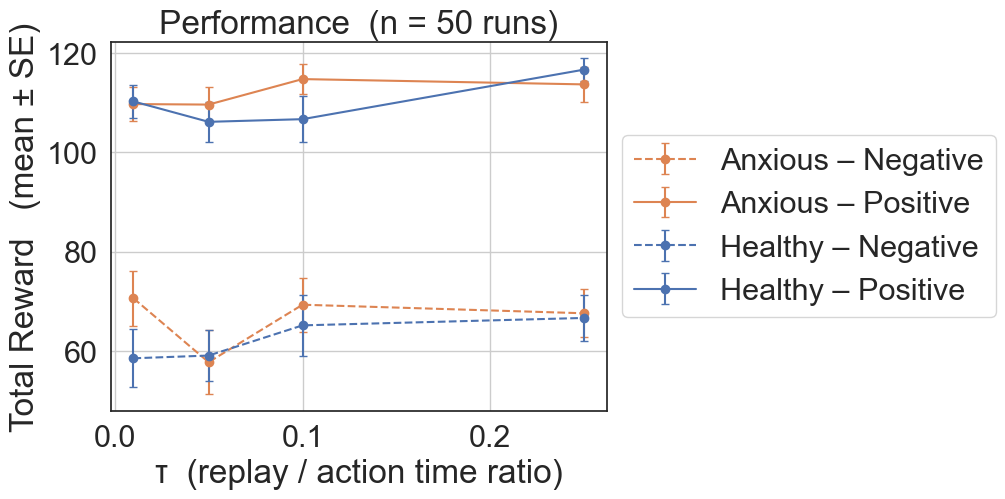

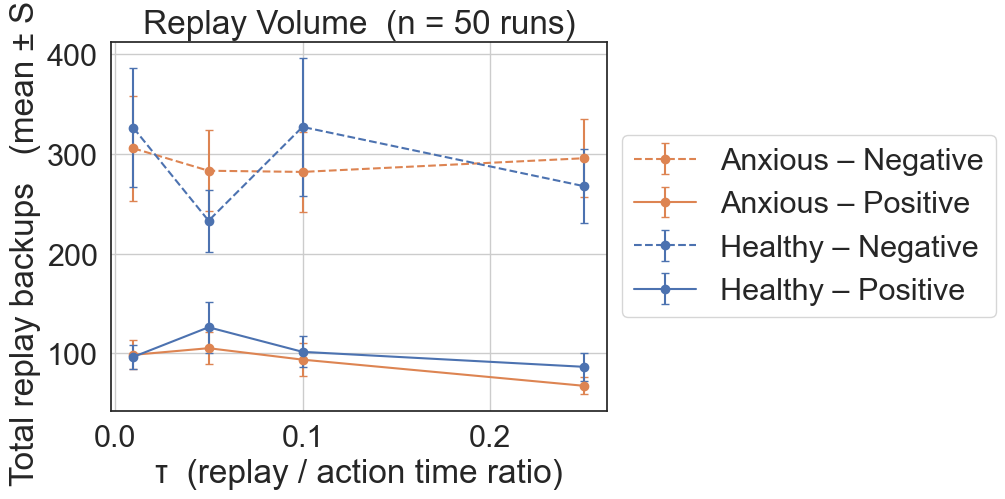

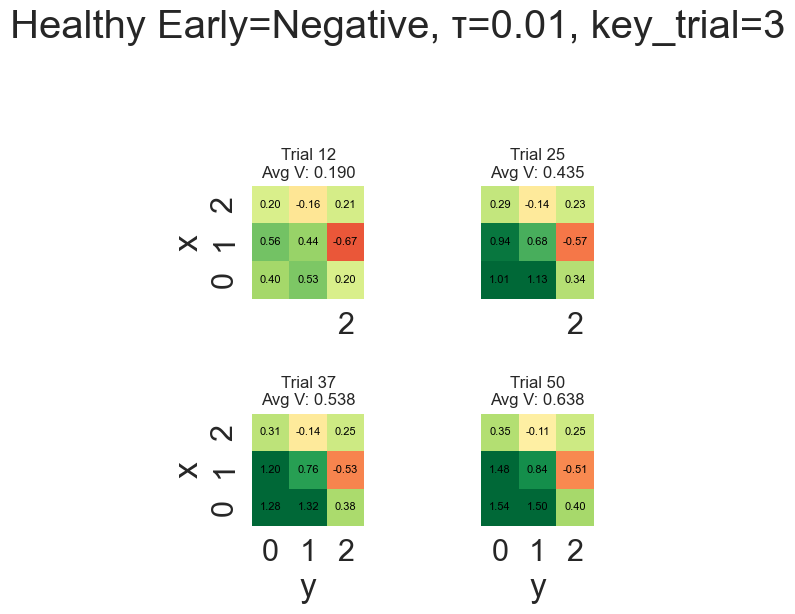

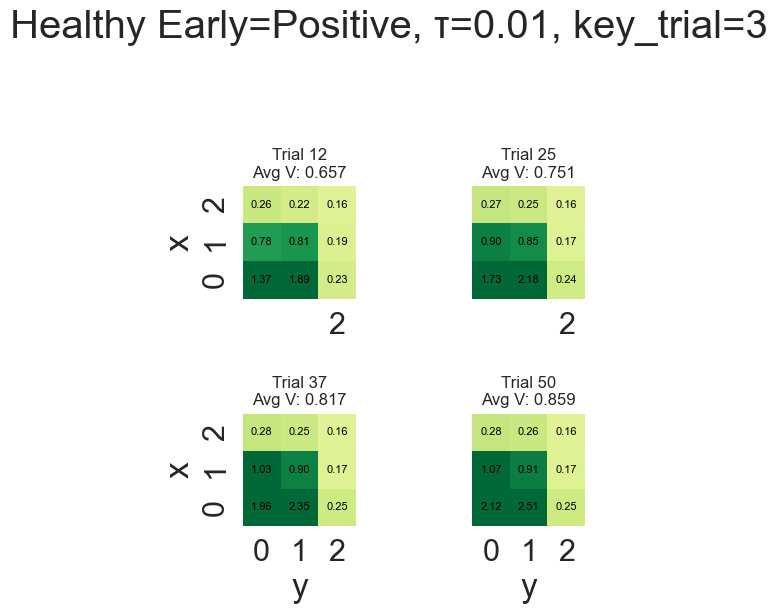

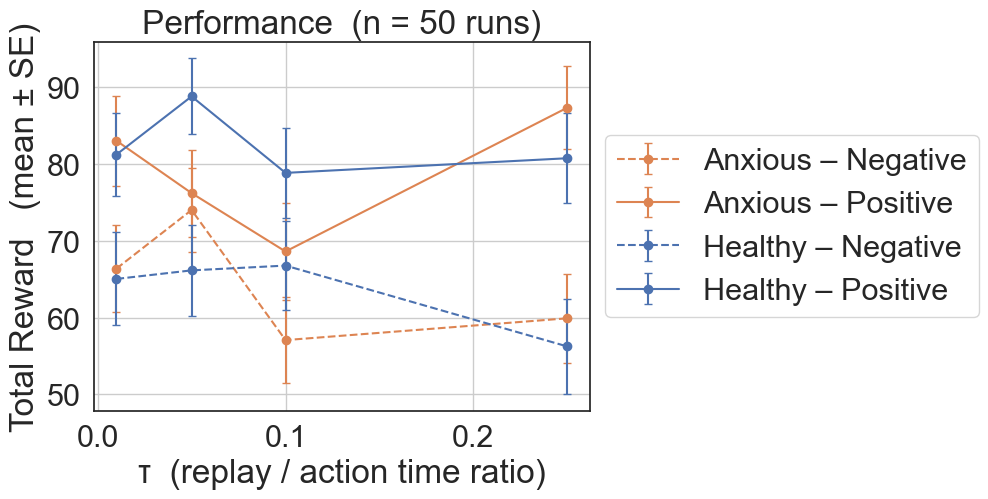

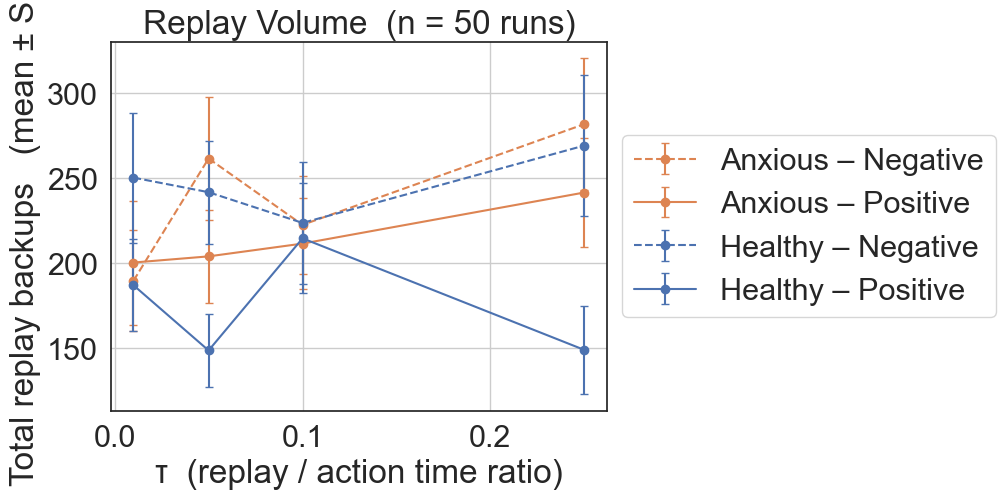

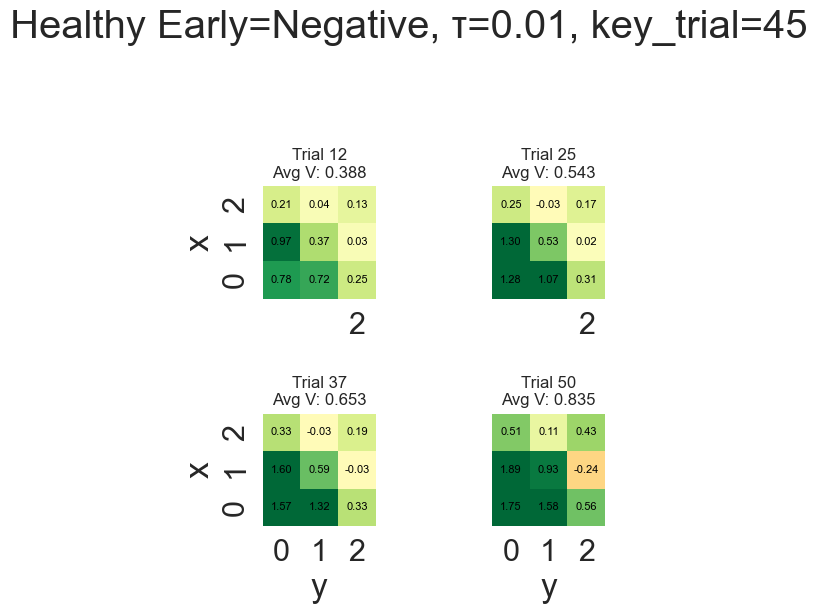

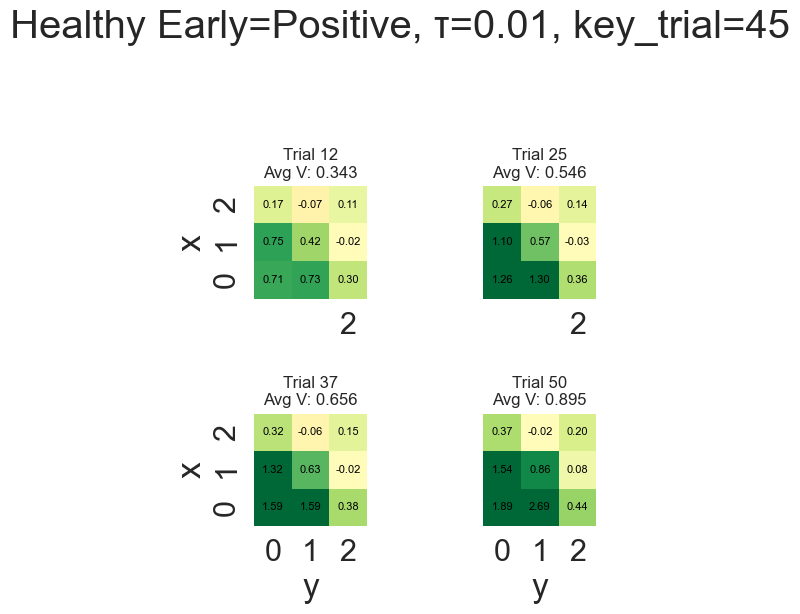

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import product
import seaborn as sns  # NEW

sns.set(style="white", font_scale=2)


for kt in [3,45]:
    # ------------------------------------------------------------
    # 1.  Environment
    # ------------------------------------------------------------
    GRID_SIZE   = 3
    ACTIONS     = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}  # U, R, D, L
    N_ACTIONS   = 4
    
    REWARD_SCALE = 5
    SMALL_REWARD_SCALE = 1  # smaller rewards for other locations
    SMALL_REWARD_PROB = 0.3  # probability of getting small reward
    PROBABILITY_SCALE=0.3
    KEY_TRIAL=kt
    TOTAL_EXPERIENCES_ONLINE=50
    TOTAL_EPISODES_ONLINE=1
    CHANGE_REWARD_INTERVAL=TOTAL_EPISODES_ONLINE/20.0
    TOTAL_EXPERIENCES_OFFLINE_TRAINING=500
    LEARNING_RATE=0.6
    
    GAMMA_ANX=0.40
    GAMMA_HEALTHY=0.50
    INV_TEMP=1
    
    # quarter points (generic; for 20 steps -> [5, 10, 15, 20])
    QUARTER_STEPS = sorted(set([
        int(TOTAL_EXPERIENCES_ONLINE * 0.25),
        int(TOTAL_EXPERIENCES_ONLINE * 0.50),
        int(TOTAL_EXPERIENCES_ONLINE * 0.75),
        TOTAL_EXPERIENCES_ONLINE
    ]))

    
    
    # ----- state ↔ index maps (for SR) ---------------------------
    state2idx = {(x, y): y + GRID_SIZE * x for x in range(GRID_SIZE) for y in range(GRID_SIZE)}
    idx2state = {v: k for k, v in state2idx.items()}
    
    # FIXED: big reward / punishment locations (same for all runs)
    REWARD_ST   = (0, 0)
    PUNISH_ST   = (GRID_SIZE-1, GRID_SIZE-1)
    
    # ------------------------------------------------------------
    # 2.  Simulation
    # ------------------------------------------------------------
    
    def simulate_condition(agent_type: str,
                       first_outcome: str,
                       tau: float,
                       n_episodes: int = TOTAL_EPISODES_ONLINE,
                       n_steps: int = TOTAL_EXPERIENCES_ONLINE,
                       n_steps_explore: int = TOTAL_EXPERIENCES_OFFLINE_TRAINING,
                       alpha: float = LEARNING_RATE,
                       gam_anx: float = GAMMA_ANX,
                       gam_healthy: float = GAMMA_HEALTHY,
                       gamma_learn: float = 0.9,
                       key_trial: int = KEY_TRIAL,
                       change_rwd: int = CHANGE_REWARD_INTERVAL,
                       beta: float = INV_TEMP,
                       td_min: float = 1e-8,
                       burst_max: int = 50,
                       rewards=0,
                       use_descending_lr: bool = True):
        """
        Run one condition and return:
        - total_reward
        - total_replay_backups
        - V_snapshots: dict {trial_step -> (GRID_SIZE x GRID_SIZE) array}
    
        If use_descending_lr=True, learning rate for Q/SR updates is:
            α(s,a) = 1 / (# experiences of taking action a in state s)
        """
        # ---------- initialise value and SR ----------------------
        Q  = np.zeros((GRID_SIZE, GRID_SIZE, N_ACTIONS))
        SR = np.zeros((GRID_SIZE ** 2, GRID_SIZE ** 2)) + (1/GRID_SIZE)
    
        # ---------- counters for dynamic learning-rates ----------
        # For SR you already had state-based counts:
        update_counts_SR  = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
        # NEW: per state–action counts for Q-learning
        update_counts_RWD = np.zeros((GRID_SIZE, GRID_SIZE, N_ACTIONS), dtype=int)
    
        # ---------- memory & bookkeeping -------------------------
        memory       = []
    
        total_replay = 0
        total_reward = 0
    
        V_snapshots = {step: np.zeros((GRID_SIZE, GRID_SIZE)) for step in QUARTER_STEPS}
    
        def alpha_SR(st):
            n = update_counts_SR[st]
            return 1.0 if n == 0 else 1.0 / n
    
        def alpha_RWD(st, a):
            n = update_counts_RWD[st + (a,)]
            return 1.0 if n == 0 else 1.0 / n

        
        
        
        def legal_actions(state,rewards):
            """Return a list of actions whose next-state ≠ current state."""
            return [a for a in range(N_ACTIONS) if step(state, a, 1, (0,0), (0,1),rewards)[0] != state]
    
        def pick_action(state, Q, rewards, beta):
            """Soft-max policy over legal actions only."""
            acts = legal_actions(state,rewards)
            if not acts:
                acts = list(range(N_ACTIONS))
            q_subset = np.array([Q[state + (a,)] for a in acts])
            p_subset = softmax(q_subset, beta)
            return np.random.choice(acts, p=p_subset)
    
        # ---------- nested: replay burst -------------------------
        def replay_burst(curr_state,first_experience):
            n_burst = 0            
            V_cost  = np.dot(softmax(Q[curr_state], beta), Q[curr_state])
            
            nonlocal total_replay, gam_anx, gam_healthy
            while n_burst < burst_max:
                
                best_evb_c, best_mem = 0, 0
    
                for (s_mem, a_mem, r_mem, s2_mem) in memory:
                    need   = SR[state2idx[curr_state], state2idx[s_mem]]
                    q_old  = Q[s_mem + (a_mem,)]
                    td     = r_mem + gamma_learn * np.max(Q[s2_mem]) - q_old
    
                    if use_descending_lr:
                        a_mem_lr = alpha_RWD(s_mem, a_mem)
                    else:
                        a_mem_lr = alpha
                    q_new = q_old + a_mem_lr * td

    
                    q_tmp          = Q[s_mem].copy()
                    q_tmp[a_mem] = q_new
                    new_policy_v = np.dot(softmax(q_tmp, beta), q_tmp)
                    old_policy_v = np.dot(softmax(Q[s_mem], beta), q_tmp)
                    
                    gain = new_policy_v - old_policy_v
    
                    if (agent_type == "Anxious" and r_mem < 0):
                        g_now = 0.5 + gam_anx
                    elif (agent_type == "Anxious" and r_mem >= 0):
                        g_now = 0.5 - gam_anx
                    else:
                        g_now = gam_healthy
    
                    evb   = need * gain
                    evb_c = ((g_now ** tau) * evb) - ((1 - g_now ** tau) * V_cost)
                    
                    if evb_c > best_evb_c:
                        best_evb_c, best_mem = evb_c, (s_mem, a_mem, q_new, r_mem)
                
                eps = 0
                if best_evb_c <= 0 + eps:
                    break
                s_b, a_b, q_new_b, r_b = best_mem
                if use_descending_lr:
                    update_counts_RWD[s_b + (a_b,)] += 1
                Q[s_b + (a_b,)] = q_new_b
                
                total_replay += 1
                n_burst += 1

            
    
        # ---------- helper: perform one exploratory SR step ------
        def sr_train_step(s_t, a_t,rewards):
            nonlocal memory
            nonlocal alpha
            update_counts_SR[s_t] += 1
            a_lr = alpha
    
            s_next, r_t = step_explore(s_t, a_t)
            if s_next == s_t:
                a_t = pick_action(s_t, Q,rewards, beta)
                s_next, r_t = step_explore(s_t, a_t)

            memory.append((s_t, a_t, r_t, s_next))
            memory = memory[:10]
    
    
            idx_s, idx_snxt = state2idx[s_t], state2idx[s_next]
            SR[idx_s, idx_s] += a_lr * (1 - SR[idx_s, idx_s])
            SR[idx_s, :]     += a_lr * (gamma_learn * SR[idx_snxt, :] - SR[idx_s, :])
    
            a_next = np.random.choice(N_ACTIONS, p=softmax(Q[s_next], beta))
            return s_next, a_next
    
        # --------------------------------------------------------
        # 2a.  SR pre-training (free exploration)
        # --------------------------------------------------------
        s_t = random.choice(list(state2idx))
        a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_t], beta))
    
        for _ in range(n_steps_explore):
            s_t, a_t = sr_train_step(s_t, a_t,rewards)
    
        # --------------------------------------------------------
        # 2b.  Main episodes with rewards & replay
        # --------------------------------------------------------
        
        for e in range(n_episodes):
            
            # ------------------------------------------------------------------
    
            # Normal episode: randomize start
            s_t = random.choice(list(state2idx))
            a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_t], beta))
    
            for t in range(n_steps):
                # Handle first experience BEFORE randomizing start
                if e == 0 and t == kt:
                    if first_outcome == "Positive":
                        # Start adjacent to reward, moving toward it
                        s_t, a_t = (0, 1), 3  # (0,1) + left → (0,0) = REWARD_ST
                    else:  # Negative
                        # Start adjacent to punishment, moving toward it  
                        s_t, a_t = (1, 2), 2  # (1,2) + down → (2,2) = PUNISH_ST
                            
                if use_descending_lr:
                    update_counts_RWD[s_t + (a_t,)] += 1
                    a_lr = alpha_RWD(s_t, a_t)
                else:
                    a_lr = alpha
                s_next, r_t = step(s_t, a_t, t, REWARD_ST, PUNISH_ST, rewards)
    
                if s_next == s_t:
                    a_t = pick_action(s_t, Q, rewards,beta)
                    s_next, r_t = step(s_t, a_t, t, REWARD_ST, PUNISH_ST, rewards)
    
                memory.append((s_t, a_t, r_t, s_next))
                memory = memory[:10]
    
                td = r_t + (gamma_learn * np.max(Q[s_next])) - Q[s_t + (a_t,)]
                Q[s_t + (a_t,)] += a_lr * td
                
                idx_s, idx_snxt = state2idx[s_t], state2idx[s_next]
                #continue training SR
                SR[idx_s, idx_s] += a_lr * (1 - SR[idx_s, idx_s])
                SR[idx_s, :]     += a_lr * (gamma_learn * SR[idx_snxt, :] - SR[idx_s, :])
    
                replay_burst(s_t,first_outcome)
    
                total_reward += r_t
            
                # -------- NEW: record V(s) at quarter trial steps --------
                trial_num = t + 1  # 1-based
                if trial_num in QUARTER_STEPS:
                    V_grid = Q.mean(axis=2)  # V(s) = max_a Q(s,a)
                
                    
                    # --------------------------------------------------------------
                
                    V_snapshots[trial_num] = V_grid.copy()
                # ---------------------------------------------------------

                # ---------------------------------------------------------
            
                a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_next], beta))
                s_t = s_next
    
        return total_reward, total_replay, V_snapshots
    
    
    # ------------------------------------------------------------
    # 3.  Parameter sweep – MANY RUNS
    # ------------------------------------------------------------
    n_runs   = 50
    tau_vals = [0.01,0.05, 0.1,0.25]
    scenarios = [
        ("Healthy", "Positive"), ("Healthy", "Negative"),
        ("Anxious", "Positive"), ("Anxious", "Negative")
    ]
    
    records = []
    value_records = []  # NEW: to store V(s) snapshots across runs

    records = []
    value_records = []

    
    for run in range(n_runs):

        # ---- sample a fixed reward map for THIS run ----
        all_states = [(i, j) for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
        neutral_states = [s for s in all_states]
        
        rewards = {
            s: random.uniform(-SMALL_REWARD_SCALE, SMALL_REWARD_SCALE)*1  # <<< continuous uniform
            for s in neutral_states
        }
        rewards[REWARD_ST]=REWARD_SCALE
        rewards[PUNISH_ST]=-REWARD_SCALE
        

        # --------------------------------------------------------
    
        for agent, first_exp in scenarios:
          
            for tau in tau_vals:
                dV, nrep, V_snaps = simulate_condition(
                    agent, first_exp, tau, rewards=rewards,use_descending_lr=True
                )
    
                records.append(dict(
                    Agent=agent,
                    FirstExperience=first_exp,
                    Tau=tau,
                    Total_Reward=dV,
                    N_Replay=nrep
                ))
    
                for trial_step, V_grid in V_snaps.items():
                    for x in range(GRID_SIZE):
                        for y in range(GRID_SIZE):
                            value_records.append(dict(
                                Agent=agent,
                                FirstExperience=first_exp,
                                Tau=tau,
                                Run=run,
                                Trial=trial_step,
                                x=x,
                                y=y,
                                V=V_grid[x, y]
                            ))

    
    results = pd.DataFrame(records)
    df_values = pd.DataFrame(value_records)

    

    # ------------------------------------------------------------
    # 4. Aggregate: mean and SE (σ / √n)
    # ------------------------------------------------------------
    agg = (
        results
        .groupby(["Agent", "FirstExperience", "Tau"])
        .agg(mean_V   = ("Total_Reward", "mean"),
             se_V     = ("Total_Reward", lambda x: x.std(ddof=1) / np.sqrt(len(x))),
             mean_R   = ("N_Replay",          "mean"),
             se_R     = ("N_Replay",          lambda x: x.std(ddof=1) / np.sqrt(len(x))))
        .reset_index()
    )

    avg_values = (
        df_values
        .groupby(["Agent", "FirstExperience", "Tau", "Trial", "x", "y"])
        ["V"].mean()
        .reset_index()
    )


    # ------------------------------------------------------------
    # 5.  Plotting: mean ± SE error bars
    # ------------------------------------------------------------
    palette = {"Healthy": "C0", "Anxious": "C1"}
    style   = {"Positive": "-", "Negative": "--"}
    
    jitter = {("Healthy", "Positive") : -0.002,
              ("Healthy", "Negative") : -0.001,
              ("Anxious", "Positive") :  0.001,
              ("Anxious", "Negative") :  0.002}

    # ---- (a) Value improvement ---------------------------------
    plt.figure()
    for (agent, first), grp in agg.groupby(["Agent", "FirstExperience"]):
        offs = jitter[(agent, first)]
        plt.errorbar(grp["Tau"], grp["mean_V"],
                     yerr=grp["se_V"], fmt="o",
                     color=palette[agent], linestyle=style[first],
                     capsize=3, label=f"{agent} – {first}")
    plt.xlabel("τ  (replay / action time ratio)")
    plt.ylabel("Total Reward   (mean ± SE)")
    plt.title(f"Performance  (n = {n_runs} runs)")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('RewardEarned_DecayingLR_trial{}_bigOutcome.png'.format(kt),dpi=300,bbox_inches='tight')
    plt.show()
  
    # ---- (b) Total replay backups ------------------------------
    plt.figure()
    for (agent, first), grp in agg.groupby(["Agent", "FirstExperience"]):
        offs = jitter[(agent, first)]
        plt.errorbar(grp["Tau"], grp["mean_R"],
                     yerr=grp["se_R"], fmt="o",
                     color=palette[agent], linestyle=style[first],
                     capsize=3, label=f"{agent} – {first}")
    plt.xlabel("τ  (replay / action time ratio)")
    plt.ylabel("Total replay backups   (mean ± SE)")
    plt.title(f"Replay Volume  (n = {n_runs} runs)")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('replays_DecayingLR_trial{}_bigOutcome.png'.format(kt),dpi=300,bbox_inches='tight')
    plt.show()
    # ------------------------------------------------------------
    # 5. Plotting: value maps via seaborn FacetGrid (visible 3x3)
    # ------------------------------------------------------------
    subset = avg_values[
        (avg_values["Agent"] == "Healthy") &
        (avg_values["FirstExperience"] == "Negative") &
        (avg_values["Tau"] == 0.01)
    ]
    
    
    
    
    
    g = sns.FacetGrid(
        subset,
        col="Trial",
        col_order=sorted(QUARTER_STEPS),
        col_wrap=2,      # <<< 2 columns -> 2x2 layout
        height=3.0,
        aspect=1.0       # <<< width = height per facet
    )
    g.map_dataframe(heatmap_func)
    
    g.set_xlabels("y")
    g.set_ylabels("x")
    g.fig.suptitle(
        f"Healthy Early=Negative, τ=0.01, key_trial={KEY_TRIAL}",
        y=1.05
    )
    
    plt.tight_layout()
    plt.show()

    subset = avg_values[
        (avg_values["Agent"] == "Healthy") &
        (avg_values["FirstExperience"] == "Positive") &
        (avg_values["Tau"] == 0.01)
    ]
    

    g = sns.FacetGrid(
        
        subset,
        col="Trial",
        col_order=sorted(QUARTER_STEPS),
        col_wrap=2,      # <<< 2 columns -> 2x2 layout
        height=3.0,
        aspect=1.0       # <<< width = height per facet
    )
    g.map_dataframe(heatmap_func)
    
    g.set_xlabels("y")
    g.set_ylabels("x")
    g.fig.suptitle(
        f"Healthy Early=Positive, τ=0.01, key_trial={KEY_TRIAL}",
        y=1.05
    )
    
    plt.tight_layout()
    plt.show()

# Approximate EVB-C! Remember last PE + $\alpha$ (to estimate gain) relative to  portion of old policy value

## $ \text{V(replay)} = \alpha|TD(s,a)_{\text{memory}}|-\frac{\text{V}(s)_\text{memory}}{\omega}$ where $\omega$ is a free parameter estimating opportunity cost

#### As you can see it produces the same qualitative results. Early negative experiences promotes greater replay and further biasing of policy, reducing avg reward earned. 

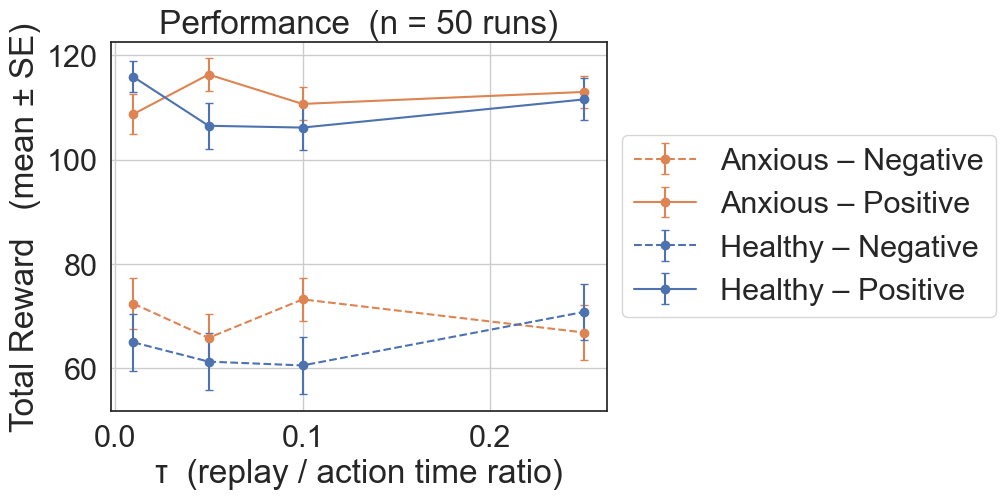

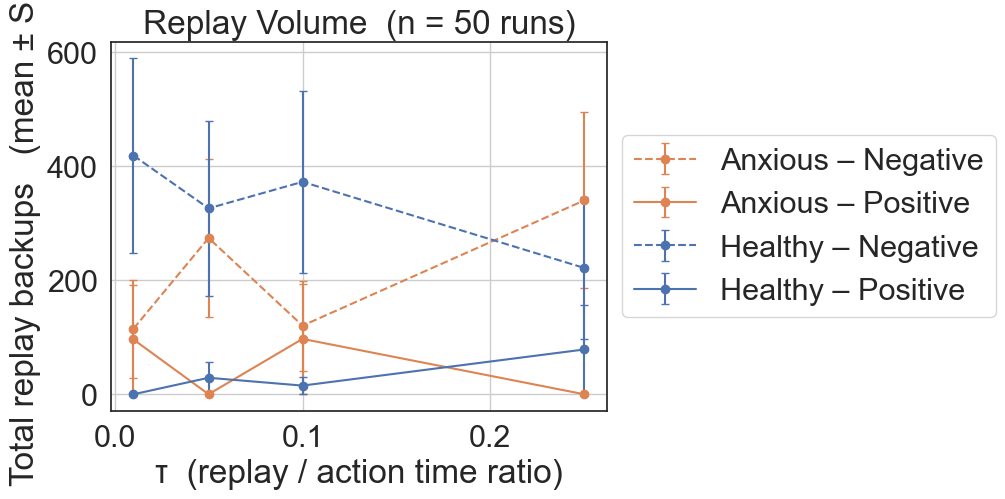

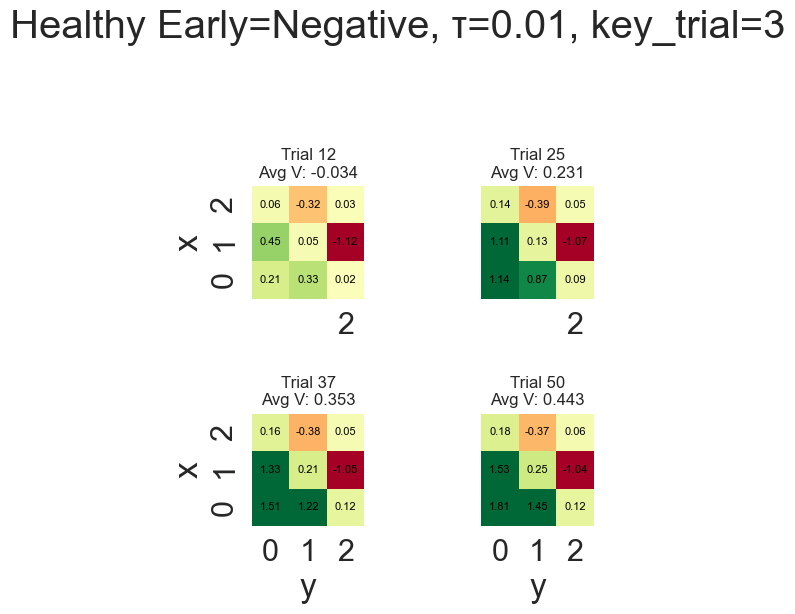

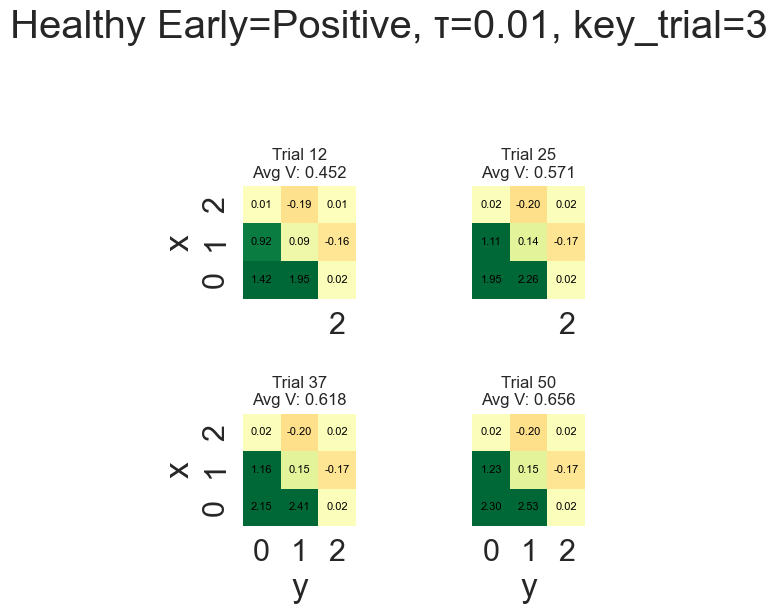

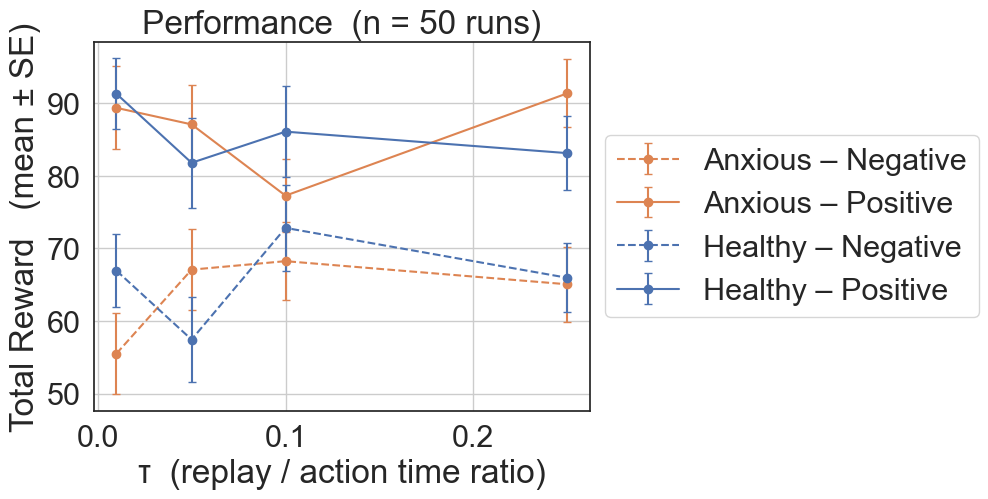

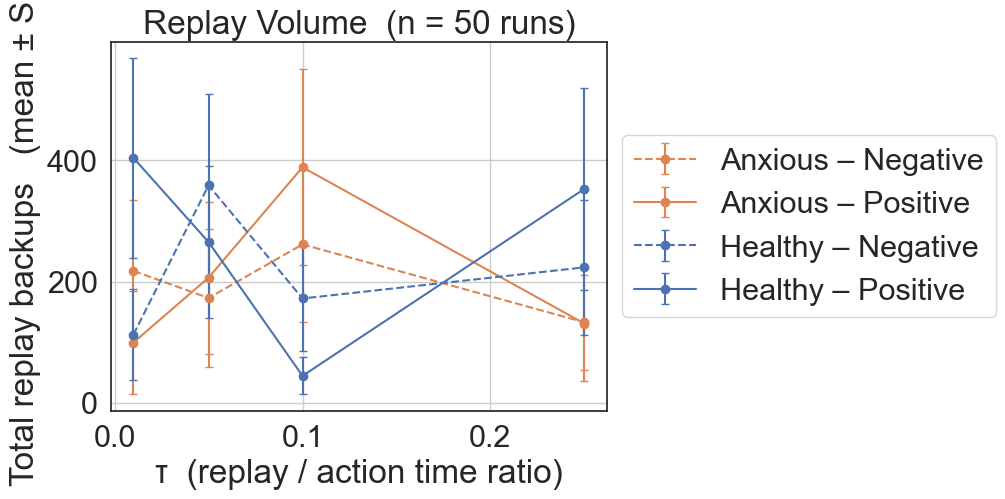

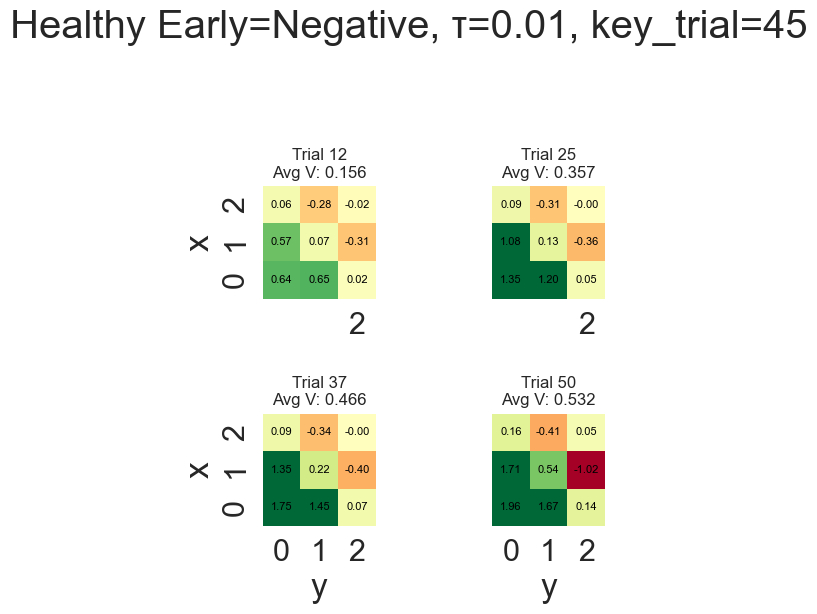

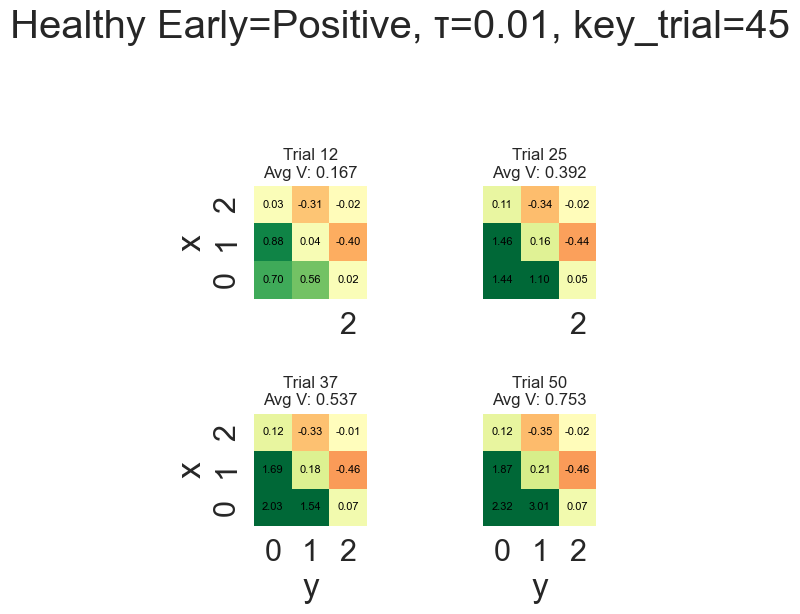

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import product
import seaborn as sns  # NEW

sns.set(style="white", font_scale=2)

for kt in [3,45]:
    # ------------------------------------------------------------
    # 1.  Environment
    # ------------------------------------------------------------
    GRID_SIZE   = 3
    ACTIONS     = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}  # U, R, D, L
    N_ACTIONS   = 4
    
    REWARD_SCALE = 5
    SMALL_REWARD_SCALE = 1  # smaller rewards for other locations
    SMALL_REWARD_PROB = 0.3  # probability of getting small reward
    PROBABILITY_SCALE=0.3
    KEY_TRIAL=kt
    TOTAL_EXPERIENCES_ONLINE=50
    TOTAL_EPISODES_ONLINE=1
    CHANGE_REWARD_INTERVAL=TOTAL_EPISODES_ONLINE/20.0
    TOTAL_EXPERIENCES_OFFLINE_TRAINING=500
    LEARNING_RATE=0.1
    
    GAMMA_ANX=0.40
    GAMMA_HEALTHY=0.50
    INV_TEMP=1
    
    # quarter points (generic; for 20 steps -> [5, 10, 15, 20])
    QUARTER_STEPS = sorted(set([
        int(TOTAL_EXPERIENCES_ONLINE * 0.25),
        int(TOTAL_EXPERIENCES_ONLINE * 0.50),
        int(TOTAL_EXPERIENCES_ONLINE * 0.75),
        TOTAL_EXPERIENCES_ONLINE
    ]))

    
    
    # ----- state ↔ index maps (for SR) ---------------------------
    state2idx = {(x, y): y + GRID_SIZE * x for x in range(GRID_SIZE) for y in range(GRID_SIZE)}
    idx2state = {v: k for k, v in state2idx.items()}
    
    # FIXED: big reward / punishment locations (same for all runs)
    REWARD_ST   = (0, 0)
    PUNISH_ST   = (GRID_SIZE-1, GRID_SIZE-1)
    
    # ------------------------------------------------------------
    # 2.  Simulation
    # ------------------------------------------------------------
    
    def simulate_condition(agent_type: str,
                       first_outcome: str,
                       tau: float,
                       n_episodes: int = TOTAL_EPISODES_ONLINE,
                       n_steps: int = TOTAL_EXPERIENCES_ONLINE,
                       n_steps_explore: int = TOTAL_EXPERIENCES_OFFLINE_TRAINING,
                       alpha: float = LEARNING_RATE,
                       gam_anx: float = GAMMA_ANX,
                       gam_healthy: float = GAMMA_HEALTHY,
                       gamma_learn: float = 0.9,
                       key_trial: int = KEY_TRIAL,
                       change_rwd: int = CHANGE_REWARD_INTERVAL,
                       beta: float = INV_TEMP,
                       td_min: float = 1e-8,
                       burst_max: int = 100,
                       rewards=0,
                       use_descending_lr: bool = False):
        """
        Run one condition and return:
        - total_reward
        - total_replay_backups
        - V_snapshots: dict {trial_step -> (GRID_SIZE x GRID_SIZE) array}
    
        If use_descending_lr=True, learning rate for Q/SR updates is:
            α(s,a) = 1 / (# experiences of taking action a in state s)
        """
        # ---------- initialise value and SR ----------------------
        Q  = np.zeros((GRID_SIZE, GRID_SIZE, N_ACTIONS))
        SR = np.zeros((GRID_SIZE ** 2, GRID_SIZE ** 2)) + (1/GRID_SIZE)
    
        # ---------- counters for dynamic learning-rates ----------
        # For SR you already had state-based counts:
        update_counts_SR  = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
        # NEW: per state–action counts for Q-learning
        update_counts_RWD = np.zeros((GRID_SIZE, GRID_SIZE, N_ACTIONS), dtype=int)
    
        # ---------- memory & bookkeeping -------------------------
        memory       = []
    
        total_replay = 0
        total_reward = 0
    
        V_snapshots = {step: np.zeros((GRID_SIZE, GRID_SIZE)) for step in QUARTER_STEPS}
    
        def alpha_SR(st):
            n = update_counts_SR[st]
            return 1.0 if n == 0 else 1.0 / n
    
        def alpha_RWD(st, a):
            n = update_counts_RWD[st + (a,)]
            return 1.0 if n == 0 else 1.0 / n

        
        
        
        def legal_actions(state,rewards):
            """Return a list of actions whose next-state ≠ current state."""
            return [a for a in range(N_ACTIONS) if step(state, a, 1, (0,0), (0,1),rewards)[0] != state]
    
        def pick_action(state, Q, rewards, beta):
            """Soft-max policy over legal actions only."""
            acts = legal_actions(state,rewards)
            if not acts:
                acts = list(range(N_ACTIONS))
            q_subset = np.array([Q[state + (a,)] for a in acts])
            p_subset = softmax(q_subset, beta)
            return np.random.choice(acts, p=p_subset)
    
        # ---------- nested: replay burst -------------------------
        def replay_burst(curr_state,first_experience):
            n_burst = 0            
            V_cost  = np.dot(softmax(Q[curr_state], beta), Q[curr_state])
            
            nonlocal total_replay, gam_anx, gam_healthy
            while n_burst < burst_max:
                
                best_evb_c, best_mem = 0, 0
                memory_counter=0
                for (s_mem, a_mem, r_mem, s2_mem,td_mem) in memory:
                    need   = SR[state2idx[curr_state], state2idx[s_mem]]
                    q_old  = Q[s_mem + (a_mem,)]
                    td     = r_mem + gamma_learn * np.max(Q[s2_mem]) - q_old
    
                    if use_descending_lr:
                        a_mem_lr = alpha_RWD(s_mem, a_mem)
                    else:
                        a_mem_lr = alpha
                    q_new = q_old + a_mem_lr * td

    
                    q_tmp          = Q[s_mem].copy()
                    q_tmp_old= Q[s_mem].copy()
                    q_tmp[a_mem] = q_new
                    new_policy_v = np.dot(softmax(q_tmp, beta), q_tmp)
                    old_policy_v = np.dot(softmax(Q[s_mem], beta), q_tmp_old)
                    
                    
    
                    evb_c = np.abs(a_mem_lr*td_mem)-(old_policy_v/5)
                    
                    
                    if evb_c > best_evb_c:
                        best_evb_c, best_mem = evb_c, (s_mem, a_mem, q_new, r_mem)
                        best_mem_counter=memory_counter
                    memory_counter+=1
                eps = 0.025
                if best_evb_c <= 0 + eps:
                    break
                s_b, a_b, q_new_b, r_b = best_mem
                if use_descending_lr:
                    update_counts_RWD[s_b + (a_b,)] += 1
                Q[s_b + (a_b,)] = q_new_b
           
                my_list = list(memory[best_mem_counter])  # Convert tuple to a list
                my_list[4] = td
                new_memory = tuple(my_list) # Convert the modified list back to a tuple
                memory[best_mem_counter]=new_memory
                
                total_replay += 1
                n_burst += 1

            
    
        # ---------- helper: perform one exploratory SR step ------
        def sr_train_step(s_t, a_t,rewards):
            nonlocal memory
            nonlocal alpha
            update_counts_SR[s_t] += 1
            a_lr = alpha
    
            s_next, r_t = step_explore(s_t, a_t)
            if s_next == s_t:
                a_t = pick_action(s_t, Q,rewards, beta)
                s_next, r_t = step_explore(s_t, a_t)

            memory.append((s_t, a_t, r_t, s_next,0))
            memory = memory[:10]
    
            # td = r_t + gamma_learn * np.max(Q[s_next]) - Q[s_t + (a_t,)]
            # Q[s_t + (a_t,)] += a_lr * td
    
            idx_s, idx_snxt = state2idx[s_t], state2idx[s_next]
            SR[idx_s, idx_s] += a_lr * (1 - SR[idx_s, idx_s])
            SR[idx_s, :]     += a_lr * (gamma_learn * SR[idx_snxt, :] - SR[idx_s, :])
    
            a_next = np.random.choice(N_ACTIONS, p=softmax(Q[s_next], beta))
            return s_next, a_next
    
        # --------------------------------------------------------
        # 2a.  SR pre-training (free exploration)
        # --------------------------------------------------------
        s_t = random.choice(list(state2idx))
        a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_t], beta))
    
        for _ in range(n_steps_explore):
            s_t, a_t = sr_train_step(s_t, a_t,rewards)
    
        # --------------------------------------------------------
        # 2b.  Main episodes with rewards & replay
        # --------------------------------------------------------
        
        for e in range(n_episodes):
            
            # ------------------------------------------------------------------
    
            # Normal episode: randomize start
            s_t = random.choice(list(state2idx))
            a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_t], beta))
    
            for t in range(n_steps):
                # Handle first experience BEFORE randomizing start
                if e == 0 and t == kt:
                    if first_outcome == "Positive":
                        # Start adjacent to reward, moving toward it
                        s_t, a_t = (0, 1), 3  # (0,1) + left → (0,0) = REWARD_ST
                    else:  # Negative
                        # Start adjacent to punishment, moving toward it  
                        s_t, a_t = (1, 2), 2  # (1,2) + down → (2,2) = PUNISH_ST
                            
                if use_descending_lr:
                    update_counts_RWD[s_t + (a_t,)] += 1
                    a_lr = alpha_RWD(s_t, a_t)
                else:
                    a_lr = alpha
                s_next, r_t = step(s_t, a_t, t, REWARD_ST, PUNISH_ST, rewards)
    
                if s_next == s_t:
                    a_t = pick_action(s_t, Q, rewards,beta)
                    s_next, r_t = step(s_t, a_t, t, REWARD_ST, PUNISH_ST, rewards)
    
               
                td = r_t + (gamma_learn * np.max(Q[s_next])) - Q[s_t + (a_t,)]
                Q[s_t + (a_t,)] += a_lr * td

                memory.append((s_t, a_t, r_t, s_next,td))
                memory = memory[:10]
    
                
                idx_s, idx_snxt = state2idx[s_t], state2idx[s_next]
                #continue training SR
                SR[idx_s, idx_s] += a_lr * (1 - SR[idx_s, idx_s])
                SR[idx_s, :]     += a_lr * (gamma_learn * SR[idx_snxt, :] - SR[idx_s, :])
    
                replay_burst(s_t,first_outcome)
    
                total_reward += r_t
            
                # -------- NEW: record V(s) at quarter trial steps --------
                trial_num = t + 1  # 1-based
                if trial_num in QUARTER_STEPS:
                    V_grid = Q.mean(axis=2)  # V(s) = max_a Q(s,a)
                
                    
                    # --------------------------------------------------------------
                
                    V_snapshots[trial_num] = V_grid.copy()
                # ---------------------------------------------------------

                # ---------------------------------------------------------
            
                a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_next], beta))
                s_t = s_next
    
        return total_reward, total_replay, V_snapshots
    
    
    # ------------------------------------------------------------
    # 3.  Parameter sweep – MANY RUNS
    # ------------------------------------------------------------
    n_runs   = 50
    tau_vals = [0.01,0.05, 0.1,0.25]
    scenarios = [
        ("Healthy", "Positive"), ("Healthy", "Negative"),
        ("Anxious", "Positive"), ("Anxious", "Negative")
    ]
    
    records = []
    value_records = []  # NEW: to store V(s) snapshots across runs

    records = []
    value_records = []

    
    for run in range(n_runs):

        # ---- sample a fixed reward map for THIS run ----
        all_states = [(i, j) for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
        neutral_states = [s for s in all_states]
        
        rewards = {
            s: random.uniform(-SMALL_REWARD_SCALE, SMALL_REWARD_SCALE)*1  # <<< continuous uniform
            for s in neutral_states
        }
        rewards[REWARD_ST]=REWARD_SCALE
        rewards[PUNISH_ST]=-REWARD_SCALE
        

        # --------------------------------------------------------
    
        for agent, first_exp in scenarios:
          
            for tau in tau_vals:
                dV, nrep, V_snaps = simulate_condition(
                    agent, first_exp, tau, rewards=rewards,use_descending_lr=True
                )
    
                records.append(dict(
                    Agent=agent,
                    FirstExperience=first_exp,
                    Tau=tau,
                    Total_Reward=dV,
                    N_Replay=nrep
                ))
    
                for trial_step, V_grid in V_snaps.items():
                    for x in range(GRID_SIZE):
                        for y in range(GRID_SIZE):
                            value_records.append(dict(
                                Agent=agent,
                                FirstExperience=first_exp,
                                Tau=tau,
                                Run=run,
                                Trial=trial_step,
                                x=x,
                                y=y,
                                V=V_grid[x, y]
                            ))

    
    results = pd.DataFrame(records)
    df_values = pd.DataFrame(value_records)

    

    # ------------------------------------------------------------
    # 4. Aggregate: mean and SE (σ / √n)
    # ------------------------------------------------------------
    agg = (
        results
        .groupby(["Agent", "FirstExperience", "Tau"])
        .agg(mean_V   = ("Total_Reward", "mean"),
             se_V     = ("Total_Reward", lambda x: x.std(ddof=1) / np.sqrt(len(x))),
             mean_R   = ("N_Replay",          "mean"),
             se_R     = ("N_Replay",          lambda x: x.std(ddof=1) / np.sqrt(len(x))))
        .reset_index()
    )

    avg_values = (
        df_values
        .groupby(["Agent", "FirstExperience", "Tau", "Trial", "x", "y"])
        ["V"].mean()
        .reset_index()
    )


    # ------------------------------------------------------------
    # 5.  Plotting: mean ± SE error bars
    # ------------------------------------------------------------
    palette = {"Healthy": "C0", "Anxious": "C1"}
    style   = {"Positive": "-", "Negative": "--"}
    
    jitter = {("Healthy", "Positive") : -0.002,
              ("Healthy", "Negative") : -0.001,
              ("Anxious", "Positive") :  0.001,
              ("Anxious", "Negative") :  0.002}

    # ---- (a) Value improvement ---------------------------------
    plt.figure()
    for (agent, first), grp in agg.groupby(["Agent", "FirstExperience"]):
        offs = jitter[(agent, first)]
        plt.errorbar(grp["Tau"], grp["mean_V"],
                     yerr=grp["se_V"], fmt="o",
                     color=palette[agent], linestyle=style[first],
                     capsize=3, label=f"{agent} – {first}")
    plt.xlabel("τ  (replay / action time ratio)")
    plt.ylabel("Total Reward   (mean ± SE)")
    plt.title(f"Performance  (n = {n_runs} runs)")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('RewardEarned_DecayingLR_trial{}_bigOutcome_APPROX.png'.format(kt),dpi=300,bbox_inches='tight')
    plt.show()
  
    # ---- (b) Total replay backups ------------------------------
    plt.figure()
    for (agent, first), grp in agg.groupby(["Agent", "FirstExperience"]):
        offs = jitter[(agent, first)]
        plt.errorbar(grp["Tau"], grp["mean_R"],
                     yerr=grp["se_R"], fmt="o",
                     color=palette[agent], linestyle=style[first],
                     capsize=3, label=f"{agent} – {first}")
    plt.xlabel("τ  (replay / action time ratio)")
    plt.ylabel("Total replay backups   (mean ± SE)")
    plt.title(f"Replay Volume  (n = {n_runs} runs)")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('replays_DecayingLR_trial{}_bigOutcome_APPROX.png'.format(kt),dpi=300,bbox_inches='tight')
    plt.show()
    # ------------------------------------------------------------
    # 5. Plotting: value maps via seaborn FacetGrid (visible 3x3)
    # ------------------------------------------------------------
    subset = avg_values[
        (avg_values["Agent"] == "Healthy") &
        (avg_values["FirstExperience"] == "Negative") &
        (avg_values["Tau"] == 0.01)
    ]
    
    
    
    
    
    g = sns.FacetGrid(
        subset,
        col="Trial",
        col_order=sorted(QUARTER_STEPS),
        col_wrap=2,      # <<< 2 columns -> 2x2 layout
        height=3.0,
        aspect=1.0       # <<< width = height per facet
    )
    g.map_dataframe(heatmap_func)
    
    g.set_xlabels("y")
    g.set_ylabels("x")
    g.fig.suptitle(
        f"Healthy Early=Negative, τ=0.01, key_trial={KEY_TRIAL}",
        y=1.05
    )
    
    plt.tight_layout()
    plt.show()

    subset = avg_values[
        (avg_values["Agent"] == "Healthy") &
        (avg_values["FirstExperience"] == "Positive") &
        (avg_values["Tau"] == 0.01)
    ]
    

    g = sns.FacetGrid(
        
        subset,
        col="Trial",
        col_order=sorted(QUARTER_STEPS),
        col_wrap=2,      # <<< 2 columns -> 2x2 layout
        height=3.0,
        aspect=1.0       # <<< width = height per facet
    )
    g.map_dataframe(heatmap_func)
    
    g.set_xlabels("y")
    g.set_ylabels("x")
    g.fig.suptitle(
        f"Healthy Early=Positive, τ=0.01, key_trial={KEY_TRIAL}",
        y=1.05
    )
    
    plt.tight_layout()
    plt.show()

# Post-Event Processing - only replaying after an event from emotionally salient memories

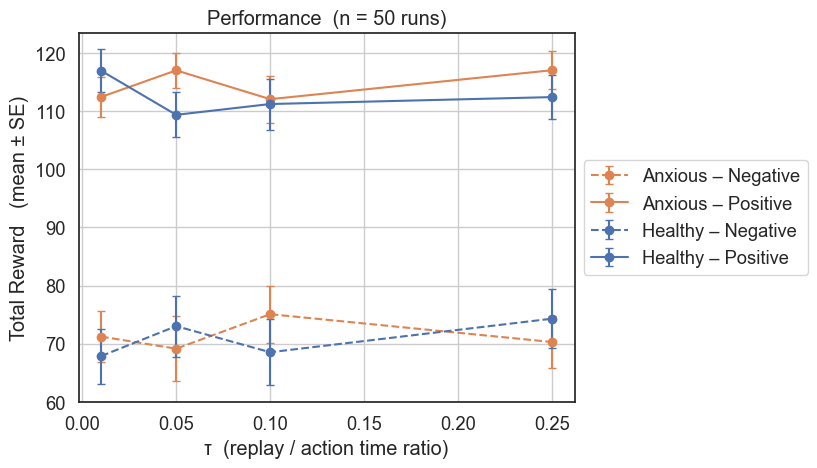

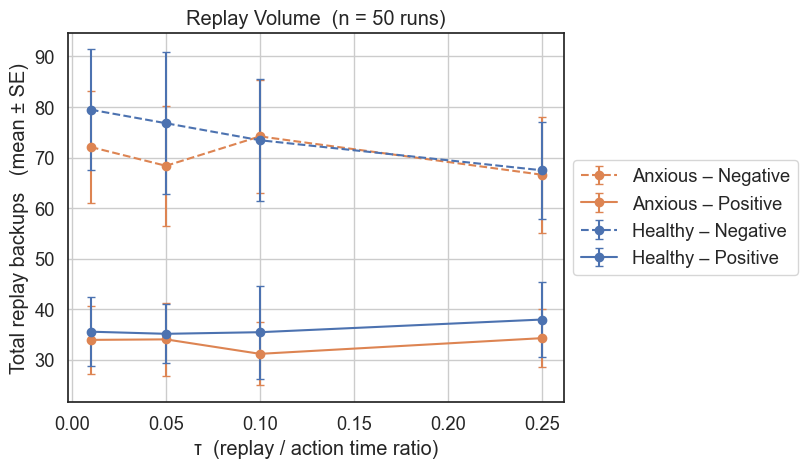

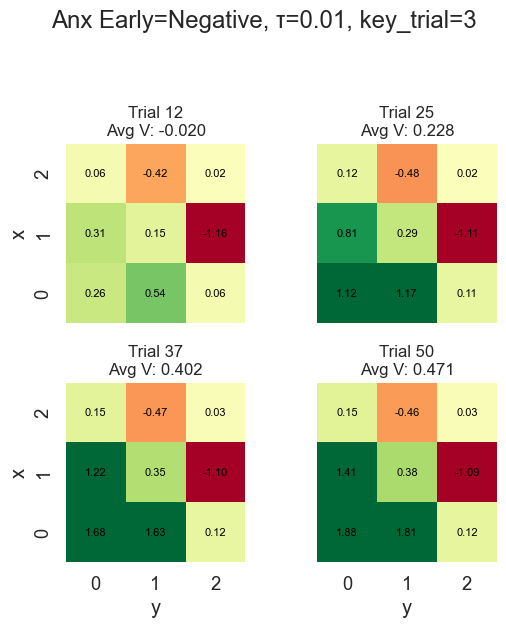

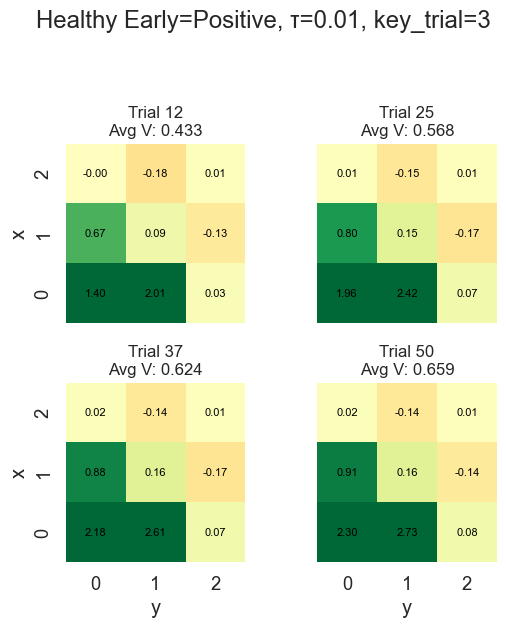

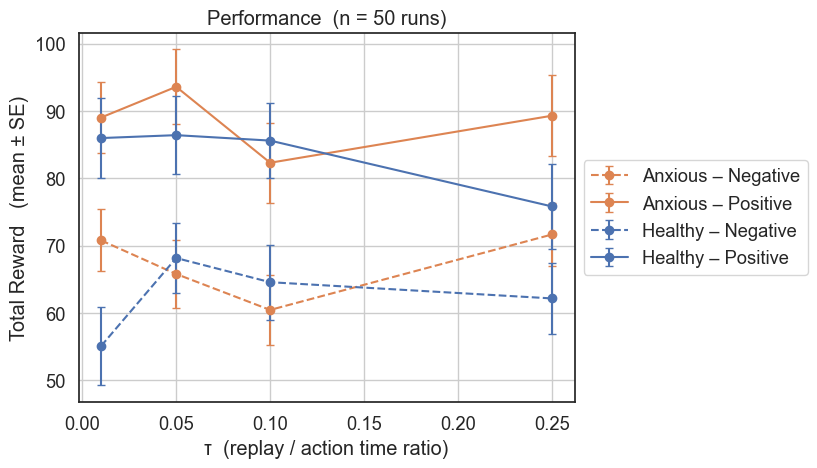

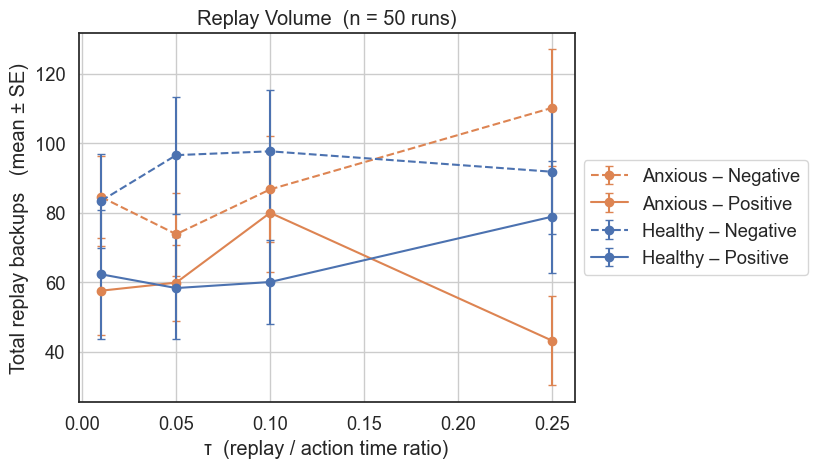

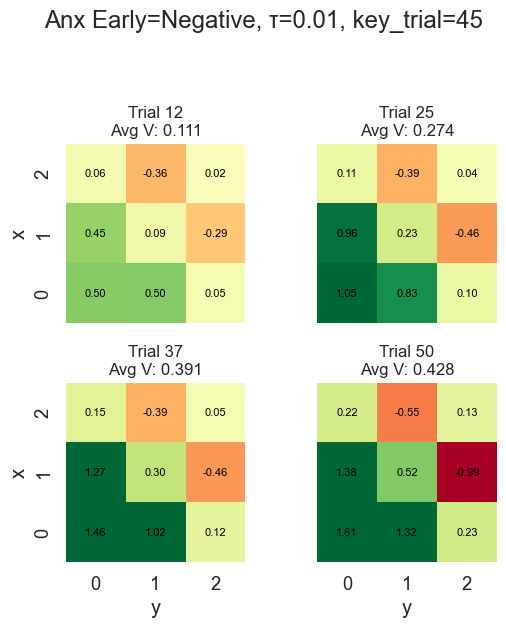

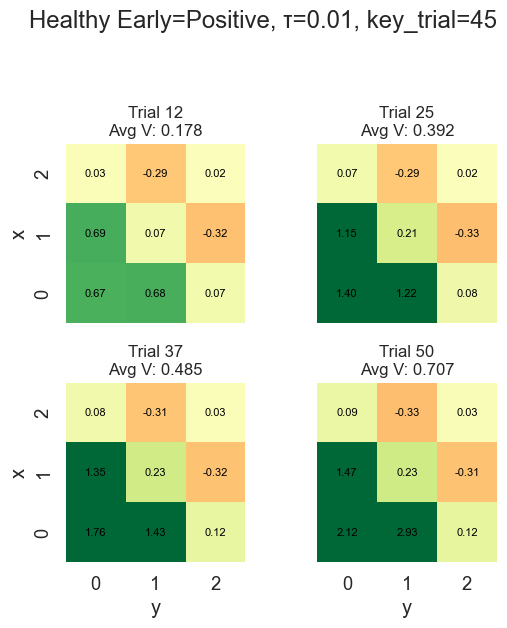

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import product
import seaborn as sns 

sns.set(style="white", font_scale=1.2) # Adjusted font scale slightly for fit


for kt in [3,45]:
    # ------------------------------------------------------------
    # 1.  Environment
    # ------------------------------------------------------------
    GRID_SIZE   = 3
    ACTIONS     = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}  # U, R, D, L
    N_ACTIONS   = 4
     
    REWARD_SCALE = 5
    SMALL_REWARD_SCALE = 1  # smaller rewards for other locations
    SMALL_REWARD_PROB = 0.3  # probability of getting small reward
    PROBABILITY_SCALE=0.3
    KEY_TRIAL=kt
    TOTAL_EXPERIENCES_ONLINE=50
    TOTAL_EPISODES_ONLINE=1
    CHANGE_REWARD_INTERVAL=TOTAL_EPISODES_ONLINE/20.0
    TOTAL_EXPERIENCES_OFFLINE_TRAINING=500
    LEARNING_RATE=0.01
     
    GAMMA_ANX=0.40
    GAMMA_HEALTHY=0.50
    INV_TEMP=1
     
    # quarter points (generic; for 20 steps -> [5, 10, 15, 20])
    QUARTER_STEPS = sorted(set([
        int(TOTAL_EXPERIENCES_ONLINE * 0.25),
        int(TOTAL_EXPERIENCES_ONLINE * 0.50),
        int(TOTAL_EXPERIENCES_ONLINE * 0.75),
        TOTAL_EXPERIENCES_ONLINE
    ]))


     
    # ----- state ↔ index maps (for SR) ---------------------------
    state2idx = {(x, y): y + GRID_SIZE * x for x in range(GRID_SIZE) for y in range(GRID_SIZE)}
    idx2state = {v: k for k, v in state2idx.items()}
     
    # FIXED: big reward / punishment locations (same for all runs)
    REWARD_ST   = (0, 0)
    PUNISH_ST   = (GRID_SIZE-1, GRID_SIZE-1)
     
    # ------------------------------------------------------------
    # 2.  Simulation
    # ------------------------------------------------------------
     
    def simulate_condition(agent_type: str,
                        first_outcome: str,
                        tau: float,
                        n_episodes: int = TOTAL_EPISODES_ONLINE,
                        n_steps: int = TOTAL_EXPERIENCES_ONLINE,
                        n_steps_explore: int = TOTAL_EXPERIENCES_OFFLINE_TRAINING,
                        alpha: float = LEARNING_RATE,
                        gam_anx: float = GAMMA_ANX,
                        gam_healthy: float = GAMMA_HEALTHY,
                        gamma_learn: float = 0.9,
                        key_trial: int = KEY_TRIAL,
                        change_rwd: int = CHANGE_REWARD_INTERVAL,
                        beta: float = INV_TEMP,
                        td_min: float = 1e-8,
                        burst_max: int = 50,
                        rewards=0,
                        use_descending_lr: bool = True):
        """
        Run one condition and return:
        - total_reward
        - total_replay_backups
        - V_snapshots: dict {trial_step -> (GRID_SIZE x GRID_SIZE) array}
     
        If use_descending_lr=True, learning rate for Q/SR updates is:
            α(s,a) = 1 / (# experiences of taking action a in state s)
        """
        # ---------- initialise value and SR ----------------------
        Q  = np.zeros((GRID_SIZE, GRID_SIZE, N_ACTIONS))
        SR = np.zeros((GRID_SIZE ** 2, GRID_SIZE ** 2)) + (1/GRID_SIZE)
     
        # ---------- counters for dynamic learning-rates ----------
        # For SR you already had state-based counts:
        update_counts_SR  = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
        # NEW: per state–action counts for Q-learning
        update_counts_RWD = np.zeros((GRID_SIZE, GRID_SIZE, N_ACTIONS), dtype=int)
     
        # ---------- memory & bookkeeping -------------------------
        memory        = []
     
        total_replay = 0
        total_reward = 0
     
        V_snapshots = {step: np.zeros((GRID_SIZE, GRID_SIZE)) for step in QUARTER_STEPS}
     
        def alpha_SR(st):
            n = update_counts_SR[st]
            return 1.0 if n == 0 else 1.0 / n
     
        def alpha_RWD(st, a):
            n = update_counts_RWD[st + (a,)]
            return 1.0 if n == 0 else 1.0 / n

        
        
        
        def legal_actions(state,rewards):
            """Return a list of actions whose next-state ≠ current state."""
            return [a for a in range(N_ACTIONS) if step(state, a, 1, (0,0), (0,1),rewards)[0] != state]
     
        def pick_action(state, Q, rewards, beta):
            """Soft-max policy over legal actions only."""
            acts = legal_actions(state,rewards)
            if not acts:
                acts = list(range(N_ACTIONS))
            q_subset = np.array([Q[state + (a,)] for a in acts])
            p_subset = softmax(q_subset, beta)
            return np.random.choice(acts, p=p_subset)
     
        # ---------- nested: replay burst -------------------------
        def replay_burst(curr_state,first_experience):
            n_burst = 0            
            V_cost  = np.dot(softmax(Q[curr_state], beta), Q[curr_state])
            
            nonlocal total_replay, gam_anx, gam_healthy
            while n_burst < burst_max:
                
                best_evb_c, best_mem = 0, 0
                memory_counter=0
                for (s_mem, a_mem, r_mem, s2_mem,td_mem) in memory:
                    need   = SR[state2idx[curr_state], state2idx[s_mem]]
                    q_old  = Q[s_mem + (a_mem,)]
                    td     = r_mem + gamma_learn * np.max(Q[s2_mem]) - q_old
    
                    if use_descending_lr:
                        a_mem_lr = alpha_RWD(s_mem, a_mem)
                    else:
                        a_mem_lr = alpha
                    q_new = q_old + a_mem_lr * td

    
                    q_tmp          = Q[s_mem].copy()
                    q_tmp_old= Q[s_mem].copy()
                    q_tmp[a_mem] = q_new
                    new_policy_v = np.dot(softmax(q_tmp, beta), q_tmp)
                    old_policy_v = np.dot(softmax(Q[s_mem], beta), q_tmp_old)
                    
                    
    
                    evb_c = np.abs(a_mem_lr*td_mem)-(old_policy_v/5)
                    
                    
                    if evb_c > best_evb_c:
                        best_evb_c, best_mem = evb_c, (s_mem, a_mem, q_new, r_mem)
                        best_mem_counter=memory_counter
                    memory_counter+=1
                eps = 0.025
                if best_evb_c <= 0 + eps:
                    break
                s_b, a_b, q_new_b, r_b = best_mem
                if use_descending_lr:
                    update_counts_RWD[s_b + (a_b,)] += 1
                Q[s_b + (a_b,)] = q_new_b
           
                my_list = list(memory[best_mem_counter])  # Convert tuple to a list
                my_list[4] = td
                new_memory = tuple(my_list) # Convert the modified list back to a tuple
                memory[best_mem_counter]=new_memory
                
                total_replay += 1
                n_burst += 1

        def replay_burst_PEP(specific_memory):
            n_burst = 0             
             
            nonlocal total_replay, gam_anx, gam_healthy
            while n_burst < burst_max:
                 
                s_mem, a_mem, r_mem, s2_mem,td_mem = specific_memory
     
                q_old  = Q[s_mem + (a_mem,)]
                
                td     = r_mem + gamma_learn * np.max(Q[s2_mem]) - q_old

                if use_descending_lr:
                    a_mem_lr = alpha_RWD(s_mem, a_mem)
                else:
                    a_mem_lr = alpha
                 
                q_new = q_old + a_mem_lr * td


                q_tmp          = Q[s_mem].copy()
                q_valueOld=np.dot(softmax(Q[s_mem],beta),q_tmp)
              
                evb_c = np.abs(a_mem_lr*td)-(q_valueOld/5)

                best_mem = (s_mem, a_mem, q_new, r_mem)
             
                 
                eps = 0
                if evb_c <= 0 + eps:
                    break
                s_b, a_b, q_new_b, r_b = best_mem
                if use_descending_lr:
                    update_counts_RWD[s_b + (a_b,)] += 1
                Q[s_b + (a_b,)] = q_new_b
                 
                total_replay += 1
                n_burst += 1
     
        # ---------- helper: perform one exploratory SR step ------
        def sr_train_step(s_t, a_t,rewards):
            nonlocal memory
            nonlocal alpha
            update_counts_SR[s_t] += 1
            a_lr = alpha
     
            s_next, r_t = step_explore(s_t, a_t)
            if s_next == s_t:
                a_t = pick_action(s_t, Q,rewards, beta)
                s_next, r_t = step_explore(s_t, a_t)

            # memory.append((s_t, a_t, r_t, s_next,0))
            # memory = memory[:10]
     
            # td = r_t + gamma_learn * np.max(Q[s_next]) - Q[s_t + (a_t,)]
            # Q[s_t + (a_t,)] += a_lr * td
     
            idx_s, idx_snxt = state2idx[s_t], state2idx[s_next]
            SR[idx_s, idx_s] += a_lr * (1 - SR[idx_s, idx_s])
            SR[idx_s, :]     += a_lr * (gamma_learn * SR[idx_snxt, :] - SR[idx_s, :])
     
            a_next = np.random.choice(N_ACTIONS, p=softmax(Q[s_next], beta))
            return s_next, a_next
     
        # --------------------------------------------------------
        # 2a.  SR pre-training (free exploration)
        # --------------------------------------------------------
        s_t = random.choice(list(state2idx))
        a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_t], beta))
     
        for _ in range(n_steps_explore):
            s_t, a_t = sr_train_step(s_t, a_t,rewards)
     
        # --------------------------------------------------------
        # 2b.  Main episodes with rewards & replay
        # --------------------------------------------------------
         
        for e in range(n_episodes):
             
            # ------------------------------------------------------------------
     
            # Normal episode: randomize start
            s_t = random.choice(list(state2idx))
            a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_t], beta))
     
            for t in range(n_steps):
                # Handle first experience BEFORE randomizing start
                if e == 0 and t == kt:
                    if first_outcome == "Positive":
                        # Start adjacent to reward, moving toward it
                        s_t, a_t = (0, 1), 3  # (0,1) + left → (0,0) = REWARD_ST
                    else:  # Negative
                        # Start adjacent to punishment, moving toward it  
                        s_t, a_t = (1, 2), 2  # (1,2) + down → (2,2) = PUNISH_ST
                            
                if use_descending_lr:
                    update_counts_RWD[s_t + (a_t,)] += 1
                    a_lr = alpha_RWD(s_t, a_t)
                else:
                    a_lr = alpha
                s_next, r_t = step(s_t, a_t, t, REWARD_ST, PUNISH_ST, rewards)
     
                if s_next == s_t:
                    a_t = pick_action(s_t, Q, rewards,beta)
                    s_next, r_t = step(s_t, a_t, t, REWARD_ST, PUNISH_ST, rewards)
     
                
                td = r_t + (gamma_learn * np.max(Q[s_next])) - Q[s_t + (a_t,)]
                Q[s_t + (a_t,)] += a_lr * td

                q_tmp_old          = Q[s_t].copy()
                old_policy_v = np.dot(softmax(Q[s_t], beta), q_tmp_old)
                evb_c = np.abs(a_lr*td)-(old_policy_v/5)
                if evb_c>0.1: #parameter governing whether the experience is BIG ENOUGH to retain for later processing
                    memory.append((s_t, a_t, r_t, s_next,td))
     
                
                idx_s, idx_snxt = state2idx[s_t], state2idx[s_next]
                #continue training SR
                SR[idx_s, idx_s] += a_lr * (1 - SR[idx_s, idx_s])
                SR[idx_s, :]     += a_lr * (gamma_learn * SR[idx_snxt, :] - SR[idx_s, :])
     
                
     
                total_reward += r_t
             
                # -------- NEW: record V(s) at quarter trial steps --------
                trial_num = t + 1  # 1-based
                if trial_num in QUARTER_STEPS:
                    V_grid = Q.mean(axis=2)  # V(s) = max_a Q(s,a)
                 
                    
                    # --------------------------------------------------------------
                 
                    V_snapshots[trial_num] = V_grid.copy()
                # ---------------------------------------------------------

                # ---------------------------------------------------------
             
                a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_next], beta))
                s_t = s_next

            for mem in memory:                 
                replay_burst_PEP(mem)
     
        return total_reward, total_replay, V_snapshots
     
     
    # ------------------------------------------------------------
    # 3.  Parameter sweep – MANY RUNS
    # ------------------------------------------------------------
    n_runs   = 50
    tau_vals = [0.01,0.05, 0.1,0.25]
    scenarios = [
        ("Healthy", "Positive"), ("Healthy", "Negative"),
        ("Anxious", "Positive"), ("Anxious", "Negative")
    ]
     
    records = []
    value_records = []  # NEW: to store V(s) snapshots across runs

    records = []
    value_records = []

     
    for run in range(n_runs):

        # ---- sample a fixed reward map for THIS run ----
        all_states = [(i, j) for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
        neutral_states = [s for s in all_states]
        
        rewards = {
            s: random.uniform(-SMALL_REWARD_SCALE, SMALL_REWARD_SCALE)*1  # <<< continuous uniform
            for s in neutral_states
        }
        rewards[REWARD_ST]=REWARD_SCALE
        rewards[PUNISH_ST]=-REWARD_SCALE
        

        # --------------------------------------------------------
     
        for agent, first_exp in scenarios:
          
            for tau in tau_vals:
                dV, nrep, V_snaps = simulate_condition(
                    agent, first_exp, tau, rewards=rewards,use_descending_lr=True
                )
     
                records.append(dict(
                    Agent=agent,
                    FirstExperience=first_exp,
                    Tau=tau,
                    Total_Reward=dV,
                    N_Replay=nrep
                ))
     
                for trial_step, V_grid in V_snaps.items():
                    for x in range(GRID_SIZE):
                        for y in range(GRID_SIZE):
                            value_records.append(dict(
                                Agent=agent,
                                FirstExperience=first_exp,
                                Tau=tau,
                                Run=run,
                                Trial=trial_step,
                                x=x,
                                y=y,
                                V=V_grid[x, y]
                            ))

     
    results = pd.DataFrame(records)
    df_values = pd.DataFrame(value_records)

     

    # ------------------------------------------------------------
    # 4. Aggregate: mean and SE (σ / √n)
    # ------------------------------------------------------------
    agg = (
        results
        .groupby(["Agent", "FirstExperience", "Tau"])
        .agg(mean_V   = ("Total_Reward", "mean"),
             se_V     = ("Total_Reward", lambda x: x.std(ddof=1) / np.sqrt(len(x))),
             mean_R   = ("N_Replay",          "mean"),
             se_R     = ("N_Replay",          lambda x: x.std(ddof=1) / np.sqrt(len(x))))
        .reset_index()
    )

    avg_values = (
        df_values
        .groupby(["Agent", "FirstExperience", "Tau", "Trial", "x", "y"])
        ["V"].mean()
        .reset_index()
    )


    # ------------------------------------------------------------
    # 5.  Plotting: mean ± SE error bars
    # ------------------------------------------------------------
    palette = {"Healthy": "C0", "Anxious": "C1"}
    style   = {"Positive": "-", "Negative": "--"}
     
    jitter = {("Healthy", "Positive") : -0.002,
              ("Healthy", "Negative") : -0.001,
              ("Anxious", "Positive") :  0.001,
              ("Anxious", "Negative") :  0.002}

    # ---- (a) Value improvement ---------------------------------
    plt.figure()
    for (agent, first), grp in agg.groupby(["Agent", "FirstExperience"]):
        offs = jitter[(agent, first)]
        plt.errorbar(grp["Tau"], grp["mean_V"],
                     yerr=grp["se_V"], fmt="o",
                     color=palette[agent], linestyle=style[first],
                     capsize=3, label=f"{agent} – {first}")
    plt.xlabel("τ  (replay / action time ratio)")
    plt.ylabel("Total Reward   (mean ± SE)")
    plt.title(f"Performance  (n = {n_runs} runs)")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('RewardEarned_DecayingLR_trial{}_bigOutcome_APPROX_PEP.png'.format(kt),dpi=300,bbox_inches='tight')
    plt.show()
   
    # ---- (b) Total replay backups ------------------------------
    plt.figure()
    for (agent, first), grp in agg.groupby(["Agent", "FirstExperience"]):
        offs = jitter[(agent, first)]
        plt.errorbar(grp["Tau"], grp["mean_R"],
                     yerr=grp["se_R"], fmt="o",
                     color=palette[agent], linestyle=style[first],
                     capsize=3, label=f"{agent} – {first}")
    plt.xlabel("τ  (replay / action time ratio)")
    plt.ylabel("Total replay backups   (mean ± SE)")
    plt.title(f"Replay Volume  (n = {n_runs} runs)")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('replays_DecayingLR_trial{}_bigOutcome_APPROX_PEP.png'.format(kt),dpi=300,bbox_inches='tight')
    plt.show()
    # ------------------------------------------------------------
    # 5. Plotting: value maps via seaborn FacetGrid (visible 3x3)
    # ------------------------------------------------------------
    subset = avg_values[
        (avg_values["Agent"] == "Healthy") &
        (avg_values["FirstExperience"] == "Negative") &
        (avg_values["Tau"] == 0.01)
    ]
     
     
     
     
     
    g = sns.FacetGrid(
        subset,
        col="Trial",
        col_order=sorted(QUARTER_STEPS),
        col_wrap=2,      # <<< 2 columns -> 2x2 layout
        height=3.0,
        aspect=1.0       # <<< width = height per facet
    )
    g.map_dataframe(heatmap_func)
     
    # Commented out so we don't overwrite the title set in heatmap_func
    # g.set_titles(col_template="Trial {col_name}")
    
    g.set_xlabels("y")
    g.set_ylabels("x")
    g.fig.suptitle(
        f"Healthy Early=Negative, τ=0.01, key_trial={KEY_TRIAL}",
        y=1.05
    )
     
    plt.tight_layout()
    plt.show()

    subset = avg_values[
        (avg_values["Agent"] == "Healthy") &
        (avg_values["FirstExperience"] == "Positive") &
        (avg_values["Tau"] == 0.01)
    ]
     

    g = sns.FacetGrid(
        subset,
        col="Trial",
        col_order=sorted(QUARTER_STEPS),
        col_wrap=2,      # <<< 2 columns -> 2x2 layout
        height=3.0,
        aspect=1.0       # <<< width = height per facet
    )
    g.map_dataframe(heatmap_func)
     
    # Commented out so we don't overwrite the title set in heatmap_func
    # g.set_titles(col_template="Trial {col_name}")

    g.set_xlabels("y")
    g.set_ylabels("x")
    g.fig.suptitle(
        f"Healthy Early=Positive, τ=0.01, key_trial={KEY_TRIAL}",
        y=1.05
    )
     
    plt.tight_layout()
    plt.show()

# The full positive feedback cycle 
### Self-monitoring -> PEP -> Worry -> Self-Monitoring...

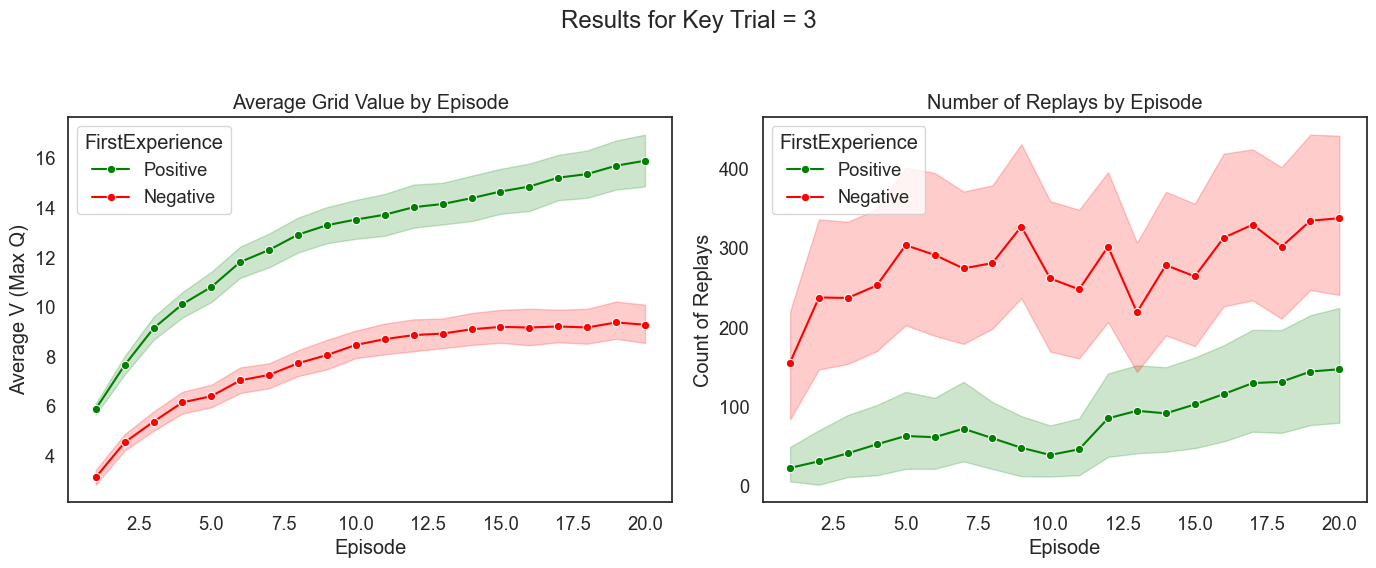

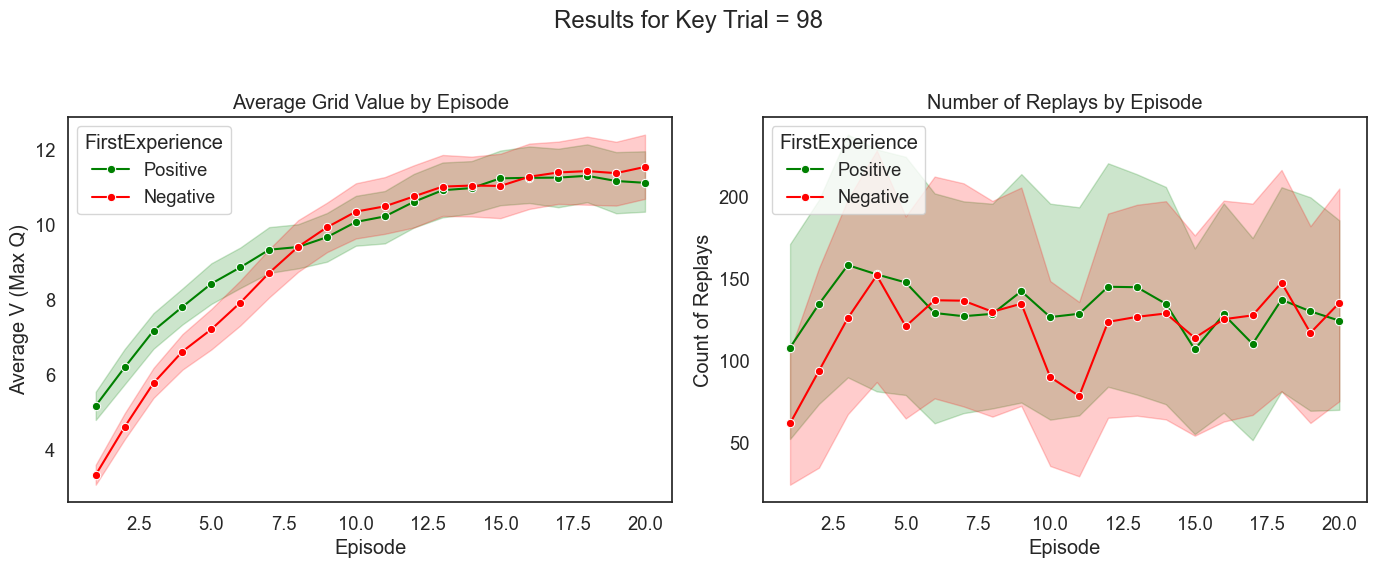

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns 

sns.set(style="white", font_scale=1.2)

# ------------------------------------------------------------
# 0. Helper Functions
# ------------------------------------------------------------

def softmax(q_values, beta):
    """Compute softmax probabilities."""
    e_x = np.exp(beta * (q_values - np.max(q_values)))
    return e_x / e_x.sum()

def step(state, action, time_step, reward_st, punish_st, rewards_dict):
    """
    Deterministic gridworld step.
    state: (row, col) tuple
    action: int (0:U, 1:R, 2:D, 3:L)
    """
    grid_size = 3
    actions = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
    
    r, c = state
    dr, dc = actions[action]
    
    nr, nc = r + dr, c + dc
    
    # Boundary checks
    if nr < 0 or nr >= grid_size or nc < 0 or nc >= grid_size:
        next_state = state
    else:
        next_state = (nr, nc)
        
    # Reward lookup
    reward = rewards_dict.get(next_state, 0.0)
    
    return next_state, reward

def step_explore(state, action):
    """Simplified step for SR exploration (no external rewards needed usually)."""
    grid_size = 3
    actions = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
    r, c = state
    dr, dc = actions[action]
    nr, nc = r + dr, c + dc
    if nr < 0 or nr >= grid_size or nc < 0 or nc >= grid_size:
        return state, 0
    return (nr, nc), 0

def heatmap_func(data, **kwargs):
    """
    Helper to plot heatmap on FacetGrid.
    Expects data with columns 'x', 'y', 'V'.
    """
    df_pivot = data.pivot(index="x", columns="y", values="V")
    sns.heatmap(df_pivot, cmap="viridis", cbar=False, annot=True, fmt=".2f")

# ------------------------------------------------------------
# 1.  Environment Setup
# ------------------------------------------------------------

for kt in [3, 98]:
    GRID_SIZE    = 3
    ACTIONS      = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}  # U, R, D, L
    N_ACTIONS    = 4
      
    REWARD_SCALE = 10
    SMALL_REWARD_SCALE = 5 
    SMALL_REWARD_PROB = 0.3 
    PROBABILITY_SCALE = 0.3
    KEY_TRIAL = kt
      
    # INCREASED EPISODES to show the loop effect over time
    TOTAL_EXPERIENCES_ONLINE = 100
    TOTAL_EPISODES_ONLINE = 20 
      
    CHANGE_REWARD_INTERVAL = TOTAL_EPISODES_ONLINE/20.0
    TOTAL_EXPERIENCES_OFFLINE_TRAINING = 200
    LEARNING_RATE = 0.1
      
    GAMMA_ANX = 0.40
    GAMMA_HEALTHY = 0.50
    INV_TEMP = 5 # Sharpness of policy
      
    QUARTER_STEPS = sorted(set([
        int(TOTAL_EXPERIENCES_ONLINE * 0.25),
        int(TOTAL_EXPERIENCES_ONLINE * 0.50),
        int(TOTAL_EXPERIENCES_ONLINE * 0.75),
        TOTAL_EXPERIENCES_ONLINE
    ]))

    state2idx = {(x, y): y + GRID_SIZE * x for x in range(GRID_SIZE) for y in range(GRID_SIZE)}
    idx2state = {v: k for k, v in state2idx.items()}
      
    REWARD_ST   = (0, 0)
    PUNISH_ST   = (GRID_SIZE-1, GRID_SIZE-1)
      
    # ------------------------------------------------------------
    # 2.  Simulation Logic
    # ------------------------------------------------------------
      
    def simulate_condition(agent_type: str,
                           first_outcome: str,
                           tau: float,
                           n_episodes: int = TOTAL_EPISODES_ONLINE,
                           n_steps: int = TOTAL_EXPERIENCES_ONLINE,
                           n_steps_explore: int = TOTAL_EXPERIENCES_OFFLINE_TRAINING,
                           alpha: float = LEARNING_RATE,
                           gam_anx: float = GAMMA_ANX,
                           gam_healthy: float = GAMMA_HEALTHY,
                           gamma_learn: float = 0.9,
                           key_trial: int = KEY_TRIAL,
                           beta: float = INV_TEMP,
                           burst_max: int = 20,
                           # Removed fixed 'rewards' arg, we generate inside
                           use_descending_lr: bool = True):
       
        # ---------- initialise value and SR ----------------------
        Q  = np.zeros((GRID_SIZE, GRID_SIZE, N_ACTIONS))
        SR = np.zeros((GRID_SIZE ** 2, GRID_SIZE ** 2)) + (1/GRID_SIZE)
      
        memory      = []
        memory_PEP  = [] # This persists across episodes -> The "Trauma" memory
      
        total_replay = 0
        total_reward = 0
      
        V_snapshots = {step: np.zeros((GRID_SIZE, GRID_SIZE)) for step in QUARTER_STEPS}
        
        # --- ADDED: Track stats per episode for plotting ---
        episode_stats = []
      
        def alpha_RWD(st, a):
            n = update_counts_RWD[st + (a,)]
            return 1.0 if n == 0 else 1.0 / n

        def pick_action(state, Q, rewards_dict, beta):
            """Soft-max policy."""
            q_vals = Q[state]
            p_vals = softmax(q_vals, beta)
            return np.random.choice(N_ACTIONS, p=p_vals)
      
        # ---------- nested: replay burst -------------------------
        def replay_burst(curr_state):
            n_burst = 0            
            V_cost  = np.dot(softmax(Q[curr_state], beta), Q[curr_state])
            
            nonlocal total_replay, gam_anx, gam_healthy
            while n_burst < burst_max:
                
                best_evb_c, best_mem = 0, 0
                memory_counter=0
                for (s_mem, a_mem, r_mem, s2_mem,td_mem) in memory:
                    need   = SR[state2idx[curr_state], state2idx[s_mem]]
                    q_old  = Q[s_mem + (a_mem,)]
                    td     = r_mem + gamma_learn * np.max(Q[s2_mem]) - q_old
   
                    if use_descending_lr:
                        a_mem_lr = alpha_RWD(s_mem, a_mem)
                    else:
                        a_mem_lr = alpha
                    q_new = q_old + a_mem_lr * td

   
                    q_tmp          = Q[s_mem].copy()
                    q_tmp_old= Q[s_mem].copy()
                    q_tmp[a_mem] = q_new
                    new_policy_v = np.dot(softmax(q_tmp, beta), q_tmp)
                    old_policy_v = np.dot(softmax(Q[s_mem], beta), q_tmp_old)
                    
                    
   
                    evb_c = np.abs(a_mem_lr*td_mem)-(old_policy_v/5)
                    
                    
                    if evb_c > best_evb_c:
                        best_evb_c, best_mem = evb_c, (s_mem, a_mem, q_new, r_mem)
                        best_mem_counter=memory_counter
                    memory_counter+=1
                eps = 0.025
                if best_evb_c <= 0 + eps:
                    break
                s_b, a_b, q_new_b, r_b = best_mem
                if use_descending_lr:
                    update_counts_RWD[s_b + (a_b,)] += 1
                Q[s_b + (a_b,)] = q_new_b
           
                my_list = list(memory[best_mem_counter])  # Convert tuple to a list
                my_list[4] = td
                new_memory = tuple(my_list) # Convert the modified list back to a tuple
                memory[best_mem_counter]=new_memory
                
                total_replay += 1
                n_burst += 1

        def replay_burst_PEP(specific_memory):
            n_burst = 0             
             
            nonlocal total_replay, gam_anx, gam_healthy
            while n_burst < burst_max:
                 
                s_mem, a_mem, r_mem, s2_mem,td_mem = specific_memory
      
                q_old  = Q[s_mem + (a_mem,)]
                
                td     = r_mem + gamma_learn * np.max(Q[s2_mem]) - q_old

                if use_descending_lr:
                    a_mem_lr = alpha_RWD(s_mem, a_mem)
                else:
                    a_mem_lr = alpha
                  
                q_new = q_old + a_mem_lr * td


                q_tmp          = Q[s_mem].copy()
                q_valueOld=np.dot(softmax(Q[s_mem],beta),q_tmp)
               
                evb_c = np.abs(a_mem_lr*td)-(q_valueOld/5)

                best_mem = (s_mem, a_mem, q_new, r_mem)
              
                  
                eps = 0
                if evb_c <= 0 + eps:
                    break
                s_b, a_b, q_new_b, r_b = best_mem
                if use_descending_lr:
                    update_counts_RWD[s_b + (a_b,)] += 1
                Q[s_b + (a_b,)] = q_new_b
                  
                total_replay += 1
                n_burst += 1

        def sr_train_step(s_t, a_t):
            nonlocal alpha
            update_counts_SR[s_t] += 1
            a_lr = alpha
      
            s_next, r_t = step_explore(s_t, a_t)
            
            idx_s, idx_snxt = state2idx[s_t], state2idx[s_next]
            SR[idx_s, idx_s] += a_lr * (1 - SR[idx_s, idx_s])
            SR[idx_s, :]     += a_lr * (gamma_learn * SR[idx_snxt, :] - SR[idx_s, :])
      
            a_next = np.random.choice(N_ACTIONS, p=softmax(Q[s_next], beta))
            return s_next, a_next
      
        # --------------------------------------------------------
        # 2a.  SR pre-training
        # --------------------------------------------------------
        # s_t = random.choice(list(state2idx))
        # a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_t], beta))
      
        # for _ in range(n_steps_explore):
        #     s_t, a_t = sr_train_step(s_t, a_t)
      
        # --------------------------------------------------------
        # 2b.  Main episodes
        # --------------------------------------------------------
        # update_counts_SR  = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)+(1/9)
        # update_counts_RWD = np.zeros((GRID_SIZE, GRID_SIZE, N_ACTIONS), dtype=int)
            
        for e in range(n_episodes):
            update_counts_SR  = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)+(1/9)
            update_counts_RWD = np.zeros((GRID_SIZE, GRID_SIZE, N_ACTIONS), dtype=int)
            
            # --- ADDED: Capture replays at start of episode ---
            start_replay_count = total_replay

            all_states = [(i, j) for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
            current_episode_rewards = {
                s: random.uniform(-SMALL_REWARD_SCALE, SMALL_REWARD_SCALE)
                for s in all_states
            }
            

            if e==0:
                current_episode_rewards[REWARD_ST] = REWARD_SCALE
                current_episode_rewards[PUNISH_ST] = -REWARD_SCALE
            
            # Normal episode start
            s_t = random.choice(list(state2idx))
            a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_t], beta))
      
            for t in range(n_steps):
                
                # --- Manipulation at Key Trial ---
                if e == 0 and t == kt:
                    if first_outcome == "Positive": 
                        s_t, a_t = (0, 1), 3 # Move to Reward
                    else:  # Negative
                        s_t, a_t = (1, 2), 2 # Move to Punish
                            
                # --- Step ---
                s_next, r_t = step(s_t, a_t, t, REWARD_ST, PUNISH_ST, current_episode_rewards)
                
                # --- Learning ---
                if use_descending_lr:
                    update_counts_RWD[s_t + (a_t,)] += 1
                    a_lr = alpha_RWD(s_t, a_t)
                else:
                    a_lr = alpha

                # Standard TD
                td = r_t + (gamma_learn * np.max(Q[s_next])) - Q[s_t + (a_t,)]
                Q[s_t + (a_t,)] += a_lr * td

                # --- Update Short Term Memory ---
                memory.append((s_t, a_t, r_t, s_next, td))
                memory = memory[:10]
   
                # --- 2. Standard Replay Burst (Within-Task) ---
                replay_burst(s_t)
   
                # --- 3. PEP Replay (Off-Task / Distortion) ---
                q_tmp_old          = Q[s_t].copy()
                old_policy_v = np.dot(softmax(Q[s_t], beta), q_tmp_old)
                evb_c = np.abs(a_lr*td)-(old_policy_v/5)
                if evb_c>0.1: 
                    memory_PEP.append((s_t, a_t, r_t, s_next, td))
      
                total_reward += r_t
                
                # Snapshotting V
                if e == 0: 
                    trial_num = t + 1
                    if trial_num in QUARTER_STEPS:
                        V_grid = Q.max(axis=2)
                        V_snapshots[trial_num] = V_grid.copy()

                # Next Action
                a_next = pick_action(s_next, Q, current_episode_rewards, beta)
                s_t = s_next
                a_t = a_next
            
            # --- ADDED: End of Episode Stats ---
            replays_in_episode = total_replay - start_replay_count
            avg_val_episode = np.mean(np.max(Q, axis=2))
            
            episode_stats.append({
                'Episode': e + 1,
                'Replays': replays_in_episode,
                'AvgGridValue': avg_val_episode
            })
      
        # --- ADDED: Return episode_stats ---
        return total_reward, total_replay, V_snapshots, episode_stats
      
      
    # ------------------------------------------------------------
    # 3.  Parameter sweep
    # ------------------------------------------------------------
    n_runs   = 100 
    tau_vals = [0.1] 
    scenarios = [
        ("Healthy", "Positive"), ("Healthy", "Negative"),
        ("Anxious", "Positive"), ("Anxious", "Negative")
    ]
      
    records = []
    value_records = []
    
    # --- ADDED: List for episode data ---
    episode_records = []
      
    for run in range(n_runs):
        for agent, first_exp in scenarios:
            for tau in tau_vals:
                # --- MODIFIED: Unpack the 4th return value ---
                dV, nrep, V_snaps, ep_stats = simulate_condition(
                    agent, first_exp, tau, use_descending_lr=True
                )
      
                records.append(dict(
                    Agent=agent,
                    FirstExperience=first_exp,
                    Tau=tau,
                    Total_Reward=dV,
                    N_Replay=nrep
                ))
                
                # --- ADDED: Collect episode stats ---
                for stat in ep_stats:
                    episode_records.append({
                        'Agent': agent,
                        'FirstExperience': first_exp,
                        'Tau': tau,
                        'Run': run,
                        'Episode': stat['Episode'],
                        'Replays': stat['Replays'],
                        'AvgGridValue': stat['AvgGridValue']
                    })
      
                for trial_step, V_grid in V_snaps.items():
                    for x in range(GRID_SIZE):
                        for y in range(GRID_SIZE):
                            value_records.append(dict(
                                Agent=agent,
                                FirstExperience=first_exp,
                                Tau=tau,
                                Run=run,
                                Trial=trial_step,
                                x=x,
                                y=y,
                                V=V_grid[x, y]
                            ))

    results = pd.DataFrame(records)
    df_values = pd.DataFrame(value_records)
    
    # --- ADDED: Create DataFrame for new plots ---
    df_episodes = pd.DataFrame(episode_records)

    # ------------------------------------------------------------
    # 4. PLOTTING (Added Below)
    # ------------------------------------------------------------
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    plt.suptitle(f"Results for Key Trial = {kt}")

    # Plot 1: Avg Value of Grid by Episode
    sns.lineplot(
        data=df_episodes, 
        x='Episode', 
        y='AvgGridValue', 
        hue='FirstExperience', 
        ax=axes[0],
        palette={'Positive': 'green', 'Negative': 'red'},
        marker="o"
    )
    axes[0].set_title("Average Grid Value by Episode")
    axes[0].set_ylabel("Average V (Max Q)")
    axes[0].set_xlabel("Episode")

    # Plot 2: Number of Replays by Episode
    sns.lineplot(
        data=df_episodes, 
        x='Episode', 
        y='Replays', 
        hue='FirstExperience', 
        ax=axes[1],
        palette={'Positive': 'green', 'Negative': 'red'},
        marker="o"
    )
    axes[1].set_title("Number of Replays by Episode")
    axes[1].set_ylabel("Count of Replays")
    axes[1].set_xlabel("Episode")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'plot_kt_{kt}.png')
    plt.show()